In [50]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [51]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2018]

In [53]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [54]:
# load gdd/kdd from cpc temperature data
if wxData == 'cpc':
    gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
elif wxData == 'era5':
    gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
    with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curKdd = pickle.load(f)
        kdd[:, :, y] = curKdd
        
    with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curGdd = pickle.load(f)
        gdd[:, :, y] = curGdd

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


In [55]:
if wxData == 'cpc':
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
elif wxData == 'era5':
    with open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
        # m -> mm
        seasonalPrecip *= 1000
        seasonalPrecip[seasonalPrecip==0] = np.nan

In [56]:
with open('%s/seasonal-et-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalEvap = pickle.load(f)
with open('%s/seasonal-sshf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSshf = pickle.load(f)
with open('%s/seasonal-slhf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSlhf = pickle.load(f)
with open('%s/seasonal-ssr-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSsr = pickle.load(f)
with open('%s/seasonal-str-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalStr = pickle.load(f)
with open('%s/seasonal-u10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalU10 = pickle.load(f)
with open('%s/seasonal-v10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalV10 = pickle.load(f)

In [57]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
with open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    kddTrends = pickle.load(f)

with open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    gddTrends = pickle.load(f)

with open('%s/evap-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    evapTrends = pickle.load(f)

with open('%s/sshf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    sshfTrends = pickle.load(f)

with open('%s/slhf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    slhfTrends = pickle.load(f)

In [58]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dataDirDiscovery
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

In [59]:
# cRange=[0, 100]
# plt.figure(figsize=(10,7))
# ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.pcolormesh(irrigationLon, irrigationLat, np.clip(irrigationData, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
# cbar = plt.colorbar(c, orientation='horizontal', pad = 0.01)
# cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 10))
# cbar.set_label('%s irrigation fraction'%crop)
# ax.coastlines()

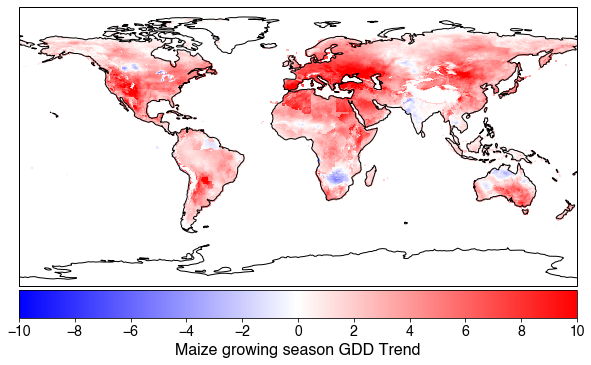

In [60]:
cRange=[-10, 10]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad = 0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

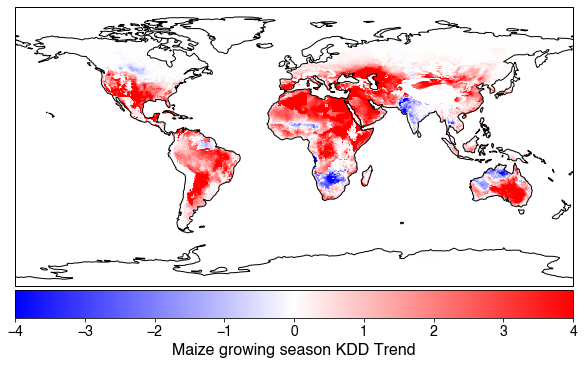

In [61]:
cRange=[-4, 4]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

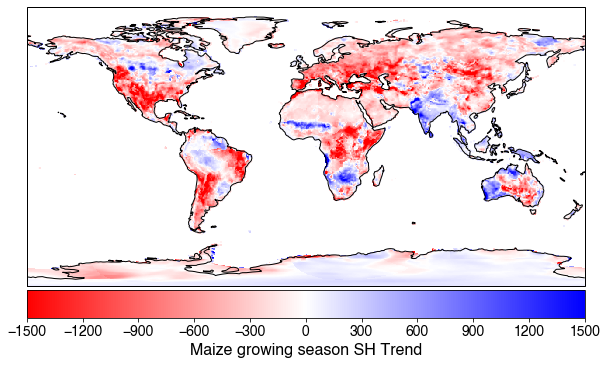

In [62]:
cRange=[-1500, 1500]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(sacksLon, sacksLat, np.clip(sshfTrends, cRange[0], cRange[1]), cmap='bwr_r', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 300))
cbar.set_label('%s growing season SH Trend'%crop)
ax.coastlines()

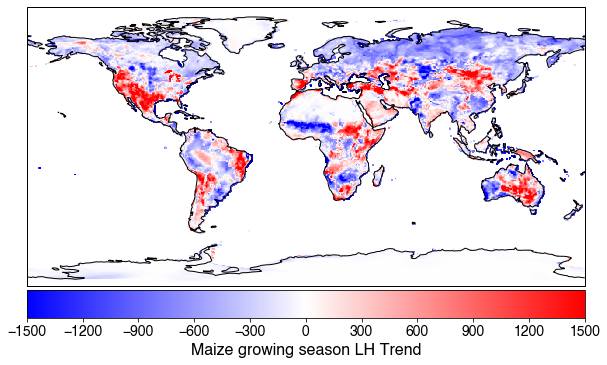

In [63]:
cRange=[-1500, 1500]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(sacksLon, sacksLat, np.clip(slhfTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 300))
cbar.set_label('%s growing season LH Trend'%crop)
ax.coastlines()

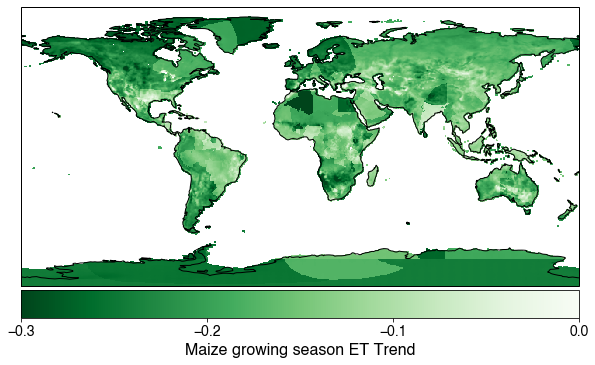

In [64]:
cRange=[-.3, 0]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(sacksLon, sacksLat, np.clip(evapTrends*1000, cRange[0], cRange[1]), cmap='Greens_r', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s growing season ET Trend'%crop)
ax.coastlines()

In [65]:
# load NASS yield data

nassCountyArea = pd.read_csv('%s/nass/maize-county-area.csv'%dataDirDiscovery)

nassPlantedArea1 = pd.read_csv('%s/nass/maize-area-planted-1961-1974.csv'%dataDirDiscovery)
nassPlantedArea2 = pd.read_csv('%s/nass/maize-area-planted-1975-1994.csv'%dataDirDiscovery)
nassPlantedArea3 = pd.read_csv('%s/nass/maize-area-planted-1995-2019.csv'%dataDirDiscovery)
nassPlantedArea = pd.concat([nassPlantedArea1[::-1], nassPlantedArea2[::-1], nassPlantedArea3[::-1]])

nassProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassProd = pd.concat([nassProd1[::-1], nassProd2[::-1], nassProd3[::-1]])

nass1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nass2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nass3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)

nass = pd.concat([nass1[::-1], nass2[::-1], nass3[::-1]])


In [66]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [67]:
nassStates = list(nass['State'])
nassStateAbvs = []
for s in nassStates:
    nassStateAbvs.append(usStateAbbrev[s.lower().title()])
nass['StateAbvs'] = nassStateAbvs

nassProdStates = list(nassProd['State'])
nassProdStateAbvs = []
for s in nassProdStates:
    nassProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassProd['StateAbvs'] = nassProdStateAbvs

nassPlantedAreaStates = list(nassPlantedArea['State'])
nassPlantedAreaStateAbvs = []
for s in nassPlantedAreaStates:
    nassPlantedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassPlantedArea['StateAbvs'] = nassPlantedAreaStateAbvs

nassCountyAreaStates = list(nassCountyArea['State'])
nassCountyAreaStateAbvs = []
for s in nassCountyAreaStates:
    nassCountyAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassCountyArea['StateAbvs'] = nassCountyAreaStateAbvs

In [68]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [69]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [70]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=False

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvap'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSshf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSlhf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalEf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSsr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalStr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalU10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalV10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeCountyArea'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeCountyIrrigationFraction'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360
            

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
    
        irrLatInds = [np.where(abs(irrigationLat-lat2) == np.nanmin(abs(irrigationLat-lat2)))[0][0],
                   np.where(abs(irrigationLat-lat1) == np.nanmin(abs(irrigationLat-lat1)))[0][0]]
        irrLonInds = [np.where(abs(irrigationLon-lon1) == np.nanmin(abs(irrigationLon-lon1)))[0][0],
                   np.where(abs(irrigationLon-lon2) == np.nanmin(abs(irrigationLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            break

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyYieldDeepak = np.nanmean(countyYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyYieldDeepak = np.squeeze(countyYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyYieldDeepak = np.pad(countyYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)
        
        irrLatIndsRange = np.arange(min(irrLatInds), max(irrLatInds)+1)
        irrLonIndsRange = np.arange(min(irrLonInds), max(irrLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
            countyEvap = np.nanmean(seasonalEvap[prLatIndsRange, :, :], axis=0)
            countySshf = np.nanmean(seasonalSshf[prLatIndsRange, :, :], axis=0)
            countySlhf = np.nanmean(seasonalSlhf[prLatIndsRange, :, :], axis=0)
            countySsr = np.nanmean(seasonalSsr[prLatIndsRange, :, :], axis=0)
            countyStr = np.nanmean(seasonalStr[prLatIndsRange, :, :], axis=0)
            countyU10 = np.nanmean(seasonalU10[prLatIndsRange, :, :], axis=0)
            countyV10 = np.nanmean(seasonalV10[prLatIndsRange, :, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])
            countyEvap = np.squeeze(seasonalEvap[prLatIndsRange, :, :])
            countySshf = np.squeeze(seasonalSshf[prLatIndsRange, :, :])
            countySlhf = np.squeeze(seasonalSlhf[prLatIndsRange, :, :])
            countySsr = np.squeeze(seasonalSsr[prLatIndsRange, :, :])
            countyStr = np.squeeze(seasonalStr[prLatIndsRange, :, :])
            countyU10 = np.squeeze(seasonalU10[prLatIndsRange, :, :])
            countyV10 = np.squeeze(seasonalV10[prLatIndsRange, :, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
            countyEvap = np.nanmean(countyEvap[prLonIndsRange, :], axis=0)
            countySshf = np.nanmean(countySshf[prLonIndsRange, :], axis=0)
            countySlhf = np.nanmean(countySlhf[prLonIndsRange, :], axis=0)
            countySsr = np.nanmean(countySsr[prLonIndsRange, :], axis=0)
            countyStr = np.nanmean(countyStr[prLonIndsRange, :], axis=0)
            countyU10 = np.nanmean(countyU10[prLonIndsRange, :], axis=0)
            countyV10 = np.nanmean(countyV10[prLonIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])
            countyEvap = np.squeeze(countyEvap[prLonIndsRange, :])
            countySshf = np.squeeze(countySshf[prLonIndsRange, :])
            countySlhf = np.squeeze(countySlhf[prLonIndsRange, :])
            countySsr = np.squeeze(countySsr[prLonIndsRange, :])
            countyStr = np.squeeze(countyStr[prLonIndsRange, :])
            countyU10 = np.squeeze(countyU10[prLonIndsRange, :])
            countyV10 = np.squeeze(countyV10[prLonIndsRange, :])

        if len(irrLatIndsRange) > 1:
            countyIrrigation = np.nanmean(irrigationData[irrLatIndsRange, :], axis=0)
        else:
            countyIrrigation = np.squeeze(irrigationData[irrLatIndsRange, :])
        
        if len(irrLonIndsRange) > 1:
            countyIrrigation = np.nanmean(countyIrrigation[irrLonIndsRange])
        else:
            countyIrrigation = np.squeeze(countyIrrigation[irrLonIndsRange])
        
        usCounties['maizeCountyIrrigationFraction'][c] = countyIrrigation
        
        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassYieldCounties = np.array(list(map(str.lower, nass['County'])))
        nassProdCounties = np.array(list(map(str.lower, nassProd['County'])))
        nassPlantedAreaCounties = np.array(list(map(str.lower, nassPlantedArea['County'])))
        nassCountyAreaCounties = np.array(list(map(str.lower, nassCountyArea['County'])))

        curStateName = usCounties['STATE'][c].lower()
        nassYieldStates = np.array(list(map(str.lower, nass['StateAbvs'])))
        nassProdStates = np.array(list(map(str.lower, nassProd['StateAbvs'])))
        nassPlantedAreaStates = np.array(list(map(str.lower, nassPlantedArea['StateAbvs'])))
        nassCountyAreaStates = np.array(list(map(str.lower, nassCountyArea['StateAbvs'])))

        countyIndYield = np.where((curCountyName == nassYieldCounties) & (curStateName == nassYieldStates))[0]
        countyIndProd = np.where((curCountyName == nassProdCounties) & (curStateName == nassProdStates))[0]
        countyIndPlantedArea = np.where((curCountyName == nassPlantedAreaCounties) & (curStateName == nassPlantedAreaStates))[0]
        countyIndCountyArea = np.where((curCountyName == nassCountyAreaCounties) & (curStateName == nassCountyAreaStates))[0]

        curCountyYieldYears = np.array(list(nass['Year']))
        curCountyYieldYears = curCountyYieldYears[countyIndYield]

        curCountyYield = np.array(list(nass['Value']))
        curCountyYield = curCountyYield[countyIndYield]
        
        curCountyProdYears = np.array(list(nassProd['Year']))
        curCountyProdYears = curCountyProdYears[countyIndProd]
        
        curCountyProd = np.array(list(nassProd['Value']))
        curCountyProd = curCountyProd[countyIndProd]
        
        curCountyPlantedAreaYears = np.array(list(nassPlantedArea['Year']))
        curCountyPlantedAreaYears = curCountyPlantedAreaYears[countyIndPlantedArea]
        
        curCountyPlantedArea = np.array(list(nassPlantedArea['Value']))
        curCountyPlantedArea = curCountyPlantedArea[countyIndPlantedArea]
        
        curCountyArea = np.array(list(nassCountyArea['Value']))
        curCountyArea = curCountyArea[countyIndCountyArea]
        curCountyArea = np.nanmean([float(a.replace(',','')) for a in curCountyArea])
        usCounties['maizeCountyArea'][c] = curCountyArea

        yieldYearsUniform = np.arange(1981, 2018+1)
        yieldUniform = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrend = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNorm = np.full(yieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(yieldYearsUniform):
                yieldUniform[indUniform] = curCountyYield[y]
        
        prodYearsUniform = np.arange(1981, 2018+1)
        prodUniform = np.full(prodYearsUniform.shape, np.nan)
        prodUniformDetrend = np.full(prodYearsUniform.shape, np.nan)
        prodUniformDetrendNorm = np.full(prodYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(prodYearsUniform):
                prodUniform[indUniform] = float(curCountyProd[y].replace(',', ''))
        
        plantedAreaYearsUniform = np.arange(1981, 2018+1)
        plantedAreaUniform = np.full(plantedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyPlantedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(plantedAreaYearsUniform):
                plantedAreaUniform[indUniform] = float(curCountyPlantedArea[y].replace(',', ''))
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(yieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            yieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(yieldUniform[indsNass]) / np.linalg.norm(scipy.signal.detrend(yieldUniform[indsNass]))
            yieldUniformDetrend[indsNass] = scipy.signal.detrend(yieldUniform[indsNass])
            yieldUniform[:ptMax[0]] = np.nan
            yieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(yieldUniform[indsNass])))
            mdl = sm.OLS(yieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
        
        ptMaxProd = findConsec(prodUniform)
        if ptMaxProd[1]-ptMaxProd[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMaxProd[0], ptMaxProd[1])
            prodUniformDetrendNorm[indsNass] = scipy.signal.detrend(prodUniform[indsNass]) / np.linalg.norm(scipy.signal.detrend(prodUniform[indsNass]))
            prodUniformDetrend[indsNass] = scipy.signal.detrend(prodUniform[indsNass])
            
            prodUniform[:ptMaxProd[0]] = np.nan
            prodUniform[ptMaxProd[1]:] = np.nan
            
            if len(np.where(np.isnan(prodUniform[ptMaxProd[0]:ptMaxProd[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(prodUniform[ptMaxProd[0]:ptMaxProd[1]+1])))
                mdl = sm.OLS(prodUniform[ptMaxProd[0]:ptMaxProd[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        ptMaxPlantedArea = findConsec(plantedAreaUniform)
        if ptMaxPlantedArea[1]-ptMaxPlantedArea[0]+1 >= minCropYears:
            plantedAreaUniform[:ptMaxPlantedArea[0]] = np.nan
            plantedAreaUniform[ptMaxPlantedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(plantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(plantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1])))
                mdl = sm.OLS(plantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1], X).fit()
                usCounties['maizePlantedAreaTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = yieldYearsUniform
        usCounties['maizeYield'][c] = yieldUniform
        usCounties['maizeYieldDetrend'][c] = yieldUniformDetrend
        usCounties['maizeYieldDetrendPlusMean'][c] = yieldUniformDetrend + np.nanmean(yieldUniform)
        usCounties['maizeYieldDetrendNorm'][c] = yieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = prodYearsUniform
        
        usCounties['maizeProd'][c] = prodUniform
        usCounties['maizeProdDetrend'][c] = prodUniformDetrend
        usCounties['maizeProdDetrendNorm'][c] = prodUniformDetrendNorm
        
        usCounties['maizePlantedAreaYears'][c] = plantedAreaYearsUniform
        usCounties['maizePlantedArea'][c] = plantedAreaUniform
        usCounties['maizePlantedAreaFraction'][c] = plantedAreaUniform/curCountyArea
            
            
        # do the same but with deepak data            
        yieldUniformDetrendDeepak = np.full(yieldYearsUniform.shape, np.nan)
        yieldUniformDetrendNormDeepak = np.full(yieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            yieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak]) / np.linalg.norm(scipy.signal.detrend(countyYieldDeepak[indsDeepak]))
            yieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyYieldDeepak[indsDeepak])
            countyYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = yieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendPlusMeanDeepak'][c] = yieldUniformDetrendDeepak + np.nanmean(countyYieldDeepak)
        usCounties['maizeYieldDetrendNormDeepak'][c] = yieldUniformDetrendNormDeepak
        
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        if len(indsPr) == len(countyPrecip):
            usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
            usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
            usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))
            X = sm.add_constant(range(len(countyPrecip[indsPr])))
            mdl = sm.OLS(countyPrecip[indsPr], X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
        
        indsEvap = np.where(~np.isnan(countyEvap))[0]
        usCounties['seasonalEvap'][c] = np.full(countyEvap.shape, np.nan)
        usCounties['seasonalEvapDetrend'][c] = np.full(countyEvap.shape, np.nan)
        usCounties['seasonalEvapDetrendNorm'][c] = np.full(countyEvap.shape, np.nan)
        if len(indsEvap) == len(countyEvap):
            usCounties['seasonalEvap'][c][indsEvap] = countyEvap[indsEvap]
            usCounties['seasonalEvapDetrend'][c][indsEvap] = scipy.signal.detrend(countyEvap[indsEvap]) 
            usCounties['seasonalEvapDetrendNorm'][c][indsEvap] = scipy.signal.detrend(countyEvap[indsEvap]) / np.linalg.norm(scipy.signal.detrend(countyEvap[indsEvap]))
            X = sm.add_constant(range(len(countyEvap[indsEvap])))
            mdl = sm.OLS(countyEvap[indsEvap], X).fit()
            usCounties['seasonalEvapTrend'][c] = mdl.params[1]
        
        indsSshf = np.where(~np.isnan(countySshf))[0]
        usCounties['seasonalSshf'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrend'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrendNorm'][c] = np.full(countySshf.shape, np.nan)
        if len(indsSshf) == len(countySshf):
            usCounties['seasonalSshf'][c][indsSshf] = countySshf[indsSshf]
            usCounties['seasonalSshfDetrend'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) 
            usCounties['seasonalSshfDetrendNorm'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) / np.linalg.norm(scipy.signal.detrend(countySshf[indsSshf]))
            X = sm.add_constant(range(len(countySshf[indsSshf])))
            mdl = sm.OLS(countySshf[indsSshf], X).fit()
            usCounties['seasonalSshfTrend'][c] = mdl.params[1]
        
        indsSlhf = np.where(~np.isnan(countySlhf))[0]
        usCounties['seasonalSlhf'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrend'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrendNorm'][c] = np.full(countySlhf.shape, np.nan)
        if len(indsSlhf) == len(countySlhf):
            usCounties['seasonalSlhf'][c][indsSlhf] = countySlhf[indsSlhf]        
            usCounties['seasonalSlhfDetrend'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) 
            usCounties['seasonalSlhfDetrendNorm'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) / np.linalg.norm(scipy.signal.detrend(countySlhf[indsSlhf]))
            X = sm.add_constant(range(len(countySlhf[indsSlhf])))
            mdl = sm.OLS(countySlhf[indsSlhf], X).fit()
            usCounties['seasonalSlhfTrend'][c] = mdl.params[1]
        
        
        countyEf = countySlhf/(countySlhf+countySshf)
        indsEf = np.where(~np.isnan(countyEf))[0]
        usCounties['seasonalEf'][c] = np.full(countyEf.shape, np.nan)
        usCounties['seasonalEfDetrend'][c] = np.full(countyEf.shape, np.nan)
        if len(indsEf) == len(countyEf):
            usCounties['seasonalEf'][c][indsEf] = countyEf[indsEf]        
            usCounties['seasonalEfDetrend'][c][indsEf] = scipy.signal.detrend(countyEf[indsEf]) 
            X = sm.add_constant(range(len(countyEf[indsEf])))
            mdl = sm.OLS(countyEf[indsEf], X).fit()
            usCounties['seasonalEfTrend'][c] = mdl.params[1]
        
        
        indsSsr = np.where(~np.isnan(countySsr))[0]
        usCounties['seasonalSsr'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrend'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrendNorm'][c] = np.full(countySsr.shape, np.nan)
        if len(indsSsr) == len(countySsr):
            usCounties['seasonalSsr'][c][indsSsr] = countySsr[indsSsr]
            usCounties['seasonalSsrDetrend'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) 
            usCounties['seasonalSsrDetrendNorm'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) / np.linalg.norm(scipy.signal.detrend(countySsr[indsSsr]))
            X = sm.add_constant(range(len(countySsr[indsSsr])))
            mdl = sm.OLS(countySsr[indsSsr], X).fit()
            usCounties['seasonalSsrTrend'][c] = mdl.params[1]
        
        
        indsStr = np.where(~np.isnan(countyStr))[0]
        usCounties['seasonalStr'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrend'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrendNorm'][c] = np.full(countyStr.shape, np.nan)
        if len(indsStr) == len(countyStr):
            usCounties['seasonalStr'][c][indsStr] = countyStr[indsStr]
            usCounties['seasonalStrDetrend'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) 
            usCounties['seasonalStrDetrendNorm'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) / np.linalg.norm(scipy.signal.detrend(countyStr[indsStr]))
            X = sm.add_constant(range(len(countyStr[indsStr])))
            mdl = sm.OLS(countyStr[indsStr], X).fit()
            usCounties['seasonalStrTrend'][c] = mdl.params[1]
        
        
        indsU10 = np.where(~np.isnan(countyU10))[0]
        usCounties['seasonalU10'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10Detrend'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10DetrendNorm'][c] = np.full(countyU10.shape, np.nan)
        if len(indsU10) == len(countyU10):
            usCounties['seasonalU10'][c][indsU10] = countyU10[indsU10]
            usCounties['seasonalU10Detrend'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) 
            usCounties['seasonalU10DetrendNorm'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) / np.linalg.norm(scipy.signal.detrend(countyU10[indsU10]))
            X = sm.add_constant(range(len(countyU10[indsU10])))
            mdl = sm.OLS(countyU10[indsU10], X).fit()
            usCounties['seasonalU10Trend'][c] = mdl.params[1]
        
        
        indsV10 = np.where(~np.isnan(countyV10))[0]
        usCounties['seasonalV10'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10Detrend'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10DetrendNorm'][c] = np.full(countyV10.shape, np.nan)
        if len(indsV10) == len(countyV10):
            usCounties['seasonalV10'][c][indsV10] = countyV10[indsV10]
            usCounties['seasonalV10Detrend'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) 
            usCounties['seasonalV10DetrendNorm'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) / np.linalg.norm(scipy.signal.detrend(countyV10[indsV10]))
            X = sm.add_constant(range(len(countyV10[indsV10])))
            mdl = sm.OLS(countyV10[indsV10], X).fit()
            usCounties['seasonalV10Trend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [71]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [72]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [73]:
usCounties = usCounties.drop(index=inds)

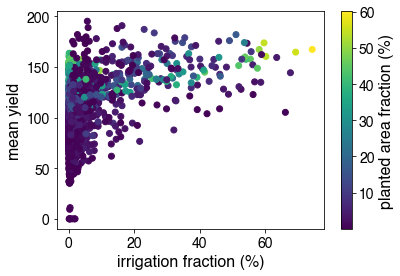

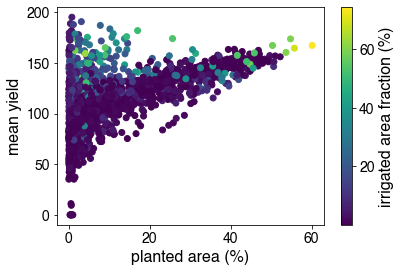

In [74]:
pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
yt = np.array([a for a in usCounties['maizeYield']])
pa = np.nanmean(pa,axis=1)*100
yt = np.nanmean(yt,axis=1)
plt.figure()
plt.scatter(ir,yt,c=pa)
plt.xlabel('irrigation fraction (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('planted area fraction (%)')

plt.figure()
plt.scatter(pa,yt,c=ir)
plt.xlabel('planted area (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('irrigated area fraction (%)')

In [75]:
yt = []
kt = []
pr = []
sh = []
lh = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 2: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrendDeepak'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        sh.append(usCounties[usCounties['STATE']==state]['seasonalSshfTrend'].mean().mean())
        lh.append(usCounties[usCounties['STATE']==state]['seasonalSlhfTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']


yield trend vs. kdd trend: coef = -6.24, p = 0.00, r2 = 0.04


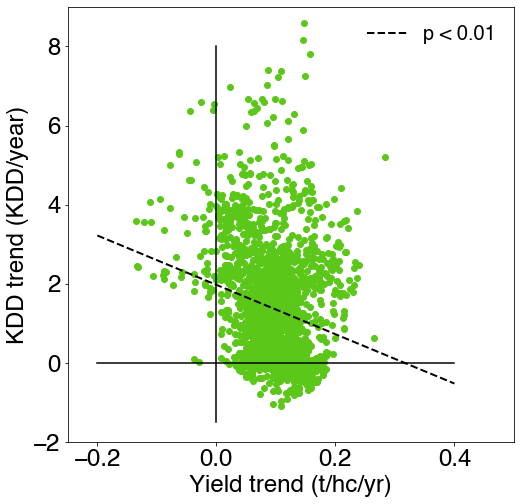

In [76]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

yieldVarDetrend = 'maizeYieldDetrendDeepak'
yieldTrendVar = 'maizeYieldTrendDeepak'
yieldVar = 'maizeYieldDeepak'

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList[yieldVarDetrend]))

nn = np.where((~np.isnan(gddAnoms)) & (~np.isnan(kddAnoms)) & (~np.isnan(yieldAnoms)))[0]
gddAnoms = gddAnoms[nn]
kddAnoms = kddAnoms[nn]
yieldAnoms = yieldAnoms[nn]

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVarDetrend]))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(yieldAnomAgg)))[0]
gddAnomAgg = gddAnomAgg[nn]
kddAnomAgg = kddAnomAgg[nn]
yieldAnomAgg = yieldAnomAgg[nn]

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
yieldTrendAgg = np.array([x for x in countyList[yieldTrendVar]])

kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVar]))])))

nn = np.where((~np.isnan(gddValsAgg)) & (~np.isnan(kddValsAgg)) & (~np.isnan(yieldValsAgg)))[0]
gddValsAgg = gddValsAgg[nn]
kddValsAgg = kddValsAgg[nn]
yieldValsAgg = yieldValsAgg[nn]

startingYields = []
for startingYield in np.array(list(countyList[yieldVar])):
    ind1 = np.where(~np.isnan(startingYield))[0][0]
    ind2 = ind1+5
    if ind2 > len(startingYield): ind2 = len(startingYield)
    startingYields.append(np.nanmean(startingYield[ind1:ind2]))
startingYields = np.array(startingYields)

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(yieldTrendAgg)) & (~np.isnan(startingYields)))[0]
kddTrendAgg = kddTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
startingYields = startingYields[nn]
    
startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(yieldTrendAgg)
mdl1 = sm.OLS(kddTrendAgg, X).fit()

x1 = -.2
x2 = .4

ax1.set_xlim([-.25, .5])
ax1.set_ylim([-2, 9])
ax1.scatter(yieldTrendAgg, kddTrendAgg, c = '#5bc718')
ax1.plot([x1, x2], mdl1.params[0]+[x1*mdl1.params[1], x2*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-.2, .4], [0, 0], '-k')
ax1.plot([0, 0], [-1.5, 8], '-k')
ax1.set_xlabel('Yield trend (t/hc/yr)', fontsize=24)
ax1.set_ylabel('KDD trend (KDD/year)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('us-kdd-trends-yield-trends.eps', format='eps', dpi=100, bbox_inches = 'tight', pad_inches = 0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f, r2 = %.2f'%(mdl1.params[1], mdl1.pvalues[1], mdl1.rsquared))


In [77]:
usCounties.keys()

Index(['STATE', 'COUNTYNAME', 'FIPS', 'LON', 'LAT', 'geometry', 'temp',
       'tempLatInds', 'tempLonInds', 'prLatInds', 'prLonInds', 'gdd', 'kdd',
       'gddTrend', 'kddTrend', 'gddDetrend', 'kddDetrend', 'gddDetrendNorm',
       'kddDetrendNorm', 'seasonalPrecip', 'seasonalPrecipTrend',
       'seasonalPrecipDetrend', 'seasonalPrecipDetrendNorm', 'seasonalEvap',
       'seasonalEvapTrend', 'seasonalEvapDetrend', 'seasonalEvapDetrendNorm',
       'seasonalSshf', 'seasonalSshfTrend', 'seasonalSshfDetrend',
       'seasonalSshfDetrendNorm', 'seasonalSlhf', 'seasonalSlhfTrend',
       'seasonalSlhfDetrend', 'seasonalSlhfDetrendNorm', 'seasonalEf',
       'seasonalEfDetrend', 'seasonalEfTrend', 'seasonalSsr',
       'seasonalSsrTrend', 'seasonalSsrDetrend', 'seasonalSsrDetrendNorm',
       'seasonalStr', 'seasonalStrTrend', 'seasonalStrDetrend',
       'seasonalStrDetrendNorm', 'seasonalU10', 'seasonalU10Trend',
       'seasonalU10Detrend', 'seasonalU10DetrendNorm', 'seasonalV10',
     

In [78]:
curCountyList = countyList.copy()

pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
pa = np.nanmean(pa,axis=1)*100

irCoords = np.arange(0, 50+1, 3)
paCoords = np.arange(0, 50+1, 3)

LH_Y_Pr_NetRad_Wind_Coef = np.full([len(irCoords),len(paCoords)], np.nan)
LH_Y_Pr_NetRad_Wind_Coef_R2 = np.full([len(irCoords),len(paCoords)], np.nan)

yieldPrGDDKDD_KDD_coef = np.full([len(irCoords),len(paCoords)], np.nan)
yieldPrGDDKDD_GDD_coef = np.full([len(irCoords),len(paCoords)], np.nan)
yieldPrGDDKDD_Pr_coef = np.full([len(irCoords),len(paCoords)], np.nan)
yieldPrGDDKDD_R2 = np.full([len(irCoords),len(paCoords)], np.nan)

for i, irThresh in enumerate(irCoords):
    for p, paThresh in enumerate(paCoords):
        if irThresh == 50:
            irInds = np.where((ir >= irThresh))[0]
        else:
            irInds = np.where((ir >= irThresh) & (ir < irThresh+10))[0]
        
        if paThresh == 50:
            paInds = np.where((pa >= paThresh))[0]
        else:
            paInds = np.where((pa >= paThresh) & (pa < paThresh+10))[0]
        
        paIrInds = np.intersect1d(irInds, paInds)

        kddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['kddDetrendNorm']))[paIrInds]])))
        gddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['gddDetrendNorm']))[paIrInds]])))
        prAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalPrecipDetrendNorm']))[paIrInds]])))
        evapAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalEvapDetrendNorm']))[paIrInds]])))
        sshfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSshfDetrendNorm']))[paIrInds]])))
        slhfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSlhfDetrendNorm']))[paIrInds]])))
        
        ssrAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSsrDetrendNorm']))[paIrInds]])))
        strAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalStrDetrendNorm']))[paIrInds]])))
        
        u10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalU10DetrendNorm']))[paIrInds]])))
        v10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalV10DetrendNorm']))[paIrInds]])))
        
        yieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['maizeYieldDetrendNormDeepak']))[paIrInds]])))
        countyFE = np.array(list(itertools.chain.from_iterable([[c]*38 for c in paIrInds])))
        
        nn = np.where((~np.isnan(kddAnomNormAgg)) & (~np.isnan(prAnomNormAgg)) & (~np.isnan(evapAnomNormAgg)) & \
                      (~np.isnan(yieldAnomNormAgg)) & (~np.isnan(sshfAnomNormAgg)) & (~np.isnan(slhfAnomNormAgg)))[0]

        if len(nn) < 5:
            continue
        
        kddAnomNormAgg = kddAnomNormAgg[nn]
        gddAnomNormAgg = gddAnomNormAgg[nn]
        sshfAnomNormAgg = sshfAnomNormAgg[nn]
        slhfAnomNormAgg = slhfAnomNormAgg[nn]
        ssrAnomNormAgg = ssrAnomNormAgg[nn]
        strAnomNormAgg = strAnomNormAgg[nn]
        
        u10AnomNormAgg = u10AnomNormAgg[nn]
        v10AnomNormAgg = v10AnomNormAgg[nn]
        
        prAnomNormAgg = prAnomNormAgg[nn]
        evapAnomNormAgg = evapAnomNormAgg[nn]
        yieldAnomNormAgg = yieldAnomNormAgg[nn]
        countyFE = countyFE[nn]
  
        data = {'KDD':kddAnomNormAgg, \
                'GDD':gddAnomNormAgg, \
                'SSHF':-sshfAnomNormAgg, \
                'SLHF':-slhfAnomNormAgg, \
                'SSR':ssrAnomNormAgg, \
                'STR':strAnomNormAgg, \
                'NetRad':(ssrAnomNormAgg+strAnomNormAgg), \
                'U10':-u10AnomNormAgg, \
                'V10':-v10AnomNormAgg, \
                'Pr':prAnomNormAgg, \
                'Evap':-evapAnomNormAgg, \
                'Yield':yieldAnomNormAgg, \
                'CountyFE':countyFE}

        df = pd.DataFrame(data, \
                          columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'NetRad', 'Pr', 'Evap', 'U10', 'V10', \
                                   'Yield', 'CountyFE'])
        
        mdl1 = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10', data=df).fit()
        LH_Y_Pr_NetRad_Wind_Coef[i,p] = mdl1.params['Yield']
        LH_Y_Pr_NetRad_Wind_Coef_R2[i,p] = mdl1.rsquared
        
        mdl1 = smf.ols(formula='Yield ~ Pr + GDD + KDD', data=df).fit()        
        yieldPrGDDKDD_R2[i,p] = mdl1.rsquared
        yieldPrGDDKDD_KDD_coef[i,p] = mdl1.params['KDD']
        yieldPrGDDKDD_GDD_coef[i,p] = mdl1.params['GDD']
        yieldPrGDDKDD_Pr_coef[i,p] = mdl1.params['Pr']
        
        

In [79]:
curCountyList = countyList.copy()

countyArea = np.array([a for a in usCounties['maizeCountyArea']])
irF = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])/100.0
irA = np.array([countyArea[i]*irF[i] for i in range(len(countyArea))])
paF = np.nanmean(np.array([a for a in usCounties['maizePlantedAreaFraction']]),axis=1)

slhfAgg = -np.nanmean(np.array([x for x in np.array(list(curCountyList['seasonalSlhf']))])/2.5e6, axis=1)
prAgg = -np.nanmean(np.array([x for x in np.array(list(curCountyList['seasonalPrecip']))]), axis=1)
yieldAgg = np.nanmean(np.array([x for x in np.array(list(curCountyList['maizeYieldDetrendDeepak']))]), axis=1)
prodAgg = np.array([yieldAgg[i]*pa[i] for i in range(len(pa))])

nn = np.where((~np.isnan(irA)) & (~np.isnan(paF)) & (~np.isnan(slhfAgg)) & (~np.isnan(prodAgg)))[0]

data = {'IR':irF[nn], 'PA':paF[nn], 'SLHF':slhfAgg[nn], 'Prod':prodAgg[nn], 'Pr':prAgg[nn]}

df = pd.DataFrame(data, \
                  columns=['IR', 'PA', 'SLHF', 'Prod', 'Pr'])
        
mdl = smf.ols(formula='SLHF ~ Prod + IR + PA + Pr', data=df).fit()

mdl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     25.18
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           5.11e-16
Time:                        16:27:30   Log-Likelihood:                -7313.9
No. Observations:                2241   AIC:                         1.464e+04
Df Residuals:                    2237   BIC:                         1.466e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.4706      0.618     33.098      0.000      19.258      21.683
Prod       -1.341e+13   7.04e+12     -1.904      0.057   -2.72e+13    3.99e+11
IR           -12.0708      1.523     -7.924      0.000     -15.058      -9.084
PA             1.1143      1.297      0.859      0.390      -1.428       3.657
Pr            -0.0125      0.033     -0.376      0.707      -0.078       0.053
==============================================================================
Omnibus:                     1382.892   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18319.080
Skew:                           2.707   Prob(JB):                         0.00
Kurtosis:                      15.918   Cond. No.                     9.72e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.09e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [80]:
slhfAgg[nn]

array([70.04064672, 20.2773725 , 19.14742956, ..., 19.66466676,
       22.25109907, 13.45752804])

In [81]:
curCountyList = countyList.copy()

countyArea = np.array([a for a in usCounties['maizeCountyArea']]) /2.47
irF = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])/100.0
irA = np.array([countyArea[i]*irF[i] for i in range(len(countyArea))])

slhfAnomAgg = -np.array([x for x in np.array(list(curCountyList['seasonalSlhfDetrend']))])/2.5e6
yieldAnomAgg = np.array([x for x in np.array(list(curCountyList['maizeYieldDetrendDeepak']))])

lhYieldSlope = []
lhYieldR2 = []
for c in range(len(irF)):
    nn = np.where((~np.isnan(slhfAnomAgg[c,:])) & (~np.isnan(yieldAnomAgg[c,:])))[0]
    if len(nn) > 10:
        X = sm.add_constant(yieldAnomAgg[c,nn])
        mdl = sm.OLS(slhfAnomAgg[c,nn], X).fit()
        lhYieldSlope.append(mdl.params[1])
        lhYieldR2.append(mdl.rsquared)
    else:
        lhYieldSlope.append(np.nan)
        lhYieldR2.append(np.nan)
lhYieldSlope = np.array(lhYieldSlope)
lhYieldR2 = np.array(lhYieldR2)

nn = np.where((~np.isnan(irF)) & (~np.isnan(lhYieldR2)))[0]
X = sm.add_constant(irF[nn])
mdlLhYieldR2 = sm.OLS(lhYieldR2[nn], X).fit()

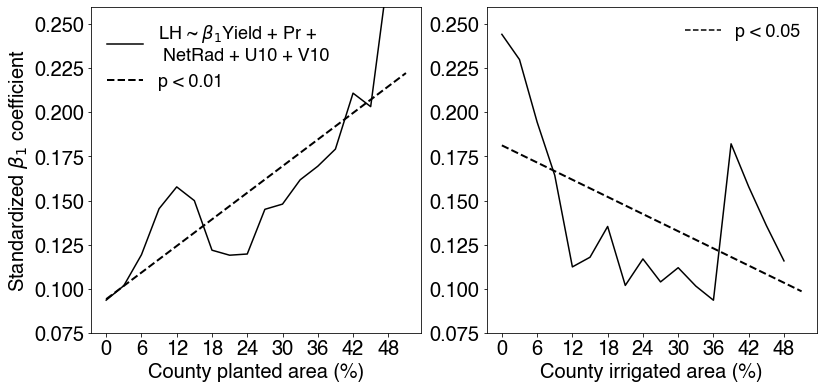

In [82]:
X = sm.add_constant(range(len(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=0))))
mdlPa = sm.OLS(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=0), X).fit()

x1 = 0
x2 = len(paCoords)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax1.set_ylim([.075, .26])
# ax1.plot(np.nanmean(lhYieldCoef,axis=0), label='LH~Yield')
# ax1.plot(np.nanmean(lhYieldPrCoef,axis=0), label='LH~Yield+Pr')
# ax1.plot(np.nanmean(lhYieldPrGDDKDDCoef,axis=0), label='LH~Yield+Pr+GDD+KDD')
# ax1.plot(np.nanmean(lhYieldPrGDDKDDSSHFCoef,axis=0), label='LH~Yield+Pr+GDD+KDD+SH')
ax1.plot(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=0), '-k', label='LH ~ $\\beta_1$Yield + Pr +\n NetRad + U10 + V10')
ax1.plot([x1, x2], [mdlPa.params[0]+x1*mdlPa.params[1], mdlPa.params[0]+x2*mdlPa.params[1]], '--k', lw=2, label='p < 0.01')
ax1.plot([0, len(paCoords)], [0, 0], '--k')
ax1.set_xlabel('County planted area (%)', fontsize=20)
ax1.set_xticks(range(0, len(paCoords), 2))
ax1.set_xticklabels(range(0, 51, 6))
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_ylabel('Standardized $\\beta_1$ coefficient', fontsize=20)
l1 = ax1.legend(prop = {'size':18, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

X = sm.add_constant(range(len(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=1))))
mdlIr = sm.OLS(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=1), X).fit()

ax2.set_ylim([.075, .26])
# ax2.plot(np.nanmean(lhYieldCoef,axis=1))
# ax2.plot(np.nanmean(lhYieldPrCoef,axis=1))
# ax2.plot(np.nanmean(lhYieldPrGDDKDDCoef,axis=1))
# ax2.plot(np.nanmean(lhYieldPrGDDKDDSSHFCoef,axis=1))
ax2.plot(np.nanmean(LH_Y_Pr_NetRad_Wind_Coef,axis=1), '-k')
ax2.plot([x1, x2], [mdlIr.params[0]+x1*mdlIr.params[1], mdlIr.params[0]+x2*mdlIr.params[1]], '--k', lw=2)
ax2.plot([0, len(irCoords)], [0, 0], '--k', label='p < 0.05')
ax2.set_xlabel('County irrigated area (%)', fontsize=20)
ax2.set_xticks(range(0, len(paCoords), 2))
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xticklabels(range(0, 51, 6))
l1 = ax2.legend(prop = {'size':18, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)


x1 = 0
x2 = .6

# ax3.scatter(irF, lhYieldR2, s=10, c='green')
# ax3.plot([x1,x2], [mdlLhYieldR2.params[0]+x1*mdlLhYieldR2.params[1], mdlLhYieldR2.params[0]+x2*mdlLhYieldR2.params[1]], '--k', lw=2, label='p < 0.01')
# ax3.set_ylabel('SLHF ~ Yield R2')
# ax3.set_xlabel('County irrigated area (ha)')
# l1 = ax3.legend(prop = {'size':12, 'family':'Helvetica'})
# l1.get_frame().set_linewidth(0)

plt.savefig('lh-yield-coef-pa-ir.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

In [83]:
curCountyList = countyList.copy()

pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
pa = np.nanmean(pa,axis=1)*100

irThresh = 0
paThresh = 0
paIrInds = np.where((ir >= irThresh) & (pa >= paThresh))[0]

# prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalPrecipDetrend']))[paIrInds,:]])))
# evapAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalEvapDetrend']))[paIrInds,:]])))
# sshfAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSshfDetrend']))[paIrInds,:]])))
# slhfAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSlhfDetrend']))[paIrInds,:]])))

# ssrAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSsrDetrend']))[paIrInds,:]])))
# strAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalStrDetrend']))[paIrInds,:]])))

# u10AnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalU10Detrend']))[paIrInds,:]])))
# v10AnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalV10Detrend']))[paIrInds,:]])))

prAnomAgg = []
sshfAnomAgg = []
slhfAnomAgg = []
ssrAnomAgg = []
strAnomAgg = []
u10AnomAgg = []
v10AnomAgg = []
yieldAnomAgg = []
for p in paIrInds:
    curY = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['maizeYieldDeepak']))[p,:]
    
    # convert from bu/ac to kg/ha
#     curY *= 25.4 * 2.47

    # convert from t/ha to kg/m2
    curY *= 1000
    
    # scale yield for county area
    curY *= pa[p]/100
    
    # reduce for harvest index
    curY *= 0.5
    
    yieldAnomAgg.extend(curY)
    
    curPr = np.array(list(curCountyList['seasonalPrecipDetrend']))[p,:]# + \
#                 np.nanmean(np.array(list(curCountyList['seasonalPrecip']))[p,:])
    prAnomAgg.extend(curPr)
    
    curSshf = np.array(list(curCountyList['seasonalSshfDetrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalSshf']))[p,:])
    sshfAnomAgg.extend(curSshf)
    
    curSlhf = np.array(list(curCountyList['seasonalSlhfDetrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalSlhf']))[p,:])
    slhfAnomAgg.extend(curSlhf)
    
    curSsr = np.array(list(curCountyList['seasonalSsrDetrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalSsr']))[p,:])
    ssrAnomAgg.extend(curSsr)
    
    curStr = np.array(list(curCountyList['seasonalStrDetrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalStr']))[p,:])
    strAnomAgg.extend(curStr)
    
    curU10 = np.array(list(curCountyList['seasonalU10Detrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalU10']))[p,:])
    u10AnomAgg.extend(curU10)
    
    curV10 = np.array(list(curCountyList['seasonalV10Detrend']))[p,:] #+ \
#                 np.nanmean(np.array(list(curCountyList['seasonalV10']))[p,:])
    v10AnomAgg.extend(curV10)
    
yieldAnomAgg = np.array(yieldAnomAgg)
prAnomAgg = np.array(prAnomAgg)
sshfAnomAgg = np.array(sshfAnomAgg)
slhfAnomAgg = np.array(slhfAnomAgg)
ssrAnomAgg = np.array(ssrAnomAgg)
strAnomAgg = np.array(strAnomAgg)
u10AnomAgg = np.array(u10AnomAgg)
v10AnomAgg = np.array(v10AnomAgg)

# convert from J/m2/growing season to mm/m2/growing season
sshfAnomAgg /= (2.5e6)
slhfAnomAgg /= (2.5e6)
ssrAnomAgg /= (2.5e6)
strAnomAgg /= (2.5e6)

# now to mm/ha/growing season
sshfAnomAgg *= 10000
slhfAnomAgg *= 10000
ssrAnomAgg *= 10000
strAnomAgg *= 10000
    
countyFE = np.array(list(itertools.chain.from_iterable([[c]*38 for c in paIrInds])))

nn = np.where((~np.isnan(prAnomAgg)) & \
              (~np.isnan(yieldAnomAgg)) & (~np.isnan(sshfAnomAgg)) & (~np.isnan(slhfAnomAgg)))[0]

sshfAnomAgg = sshfAnomAgg[nn]
slhfAnomAgg = slhfAnomAgg[nn]
ssrAnomAgg = ssrAnomAgg[nn]
strAnomAgg = strAnomAgg[nn]
u10AnomAgg = u10AnomAgg[nn]
v10AnomAgg = v10AnomAgg[nn]
prAnomAgg = prAnomAgg[nn]
yieldAnomAgg = yieldAnomAgg[nn]
countyFE = countyFE[nn]

data = {'SSHF':-sshfAnomAgg, \
        'SLHF':-slhfAnomAgg, \
        'NetHF':-(sshfAnomAgg+slhfAnomAgg), \
        'SSR':ssrAnomAgg, \
        'STR':strAnomAgg, \
        'U10':-u10AnomAgg, \
        'V10':-v10AnomAgg, \
        'NetRad':(ssrAnomAgg+strAnomAgg), \
        'Pr':prAnomAgg, \
        'Yield':yieldAnomAgg, \
        'CountyFE':countyFE}

df = pd.DataFrame(data, \
                  columns=['SLHF', 'SSHF', 'SSR', 'STR', 'U10', 'V10', 'NetRad', 'Pr', 'NetHF', \
                           'Yield', 'CountyFE'])

mdl_LH_Y = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10', data=df).fit()
# mdl1 = smf.ols(formula='SLHF ~ Yield + Pr + C(CountyFE)', data=df).fit()
mdl_LH_Y.summary()

# mdl_LH_SH = smf.ols(formula='SSHF ~ SLHF', data=df).fit()
# mdl_LH_SH.summary()

# mdl_SH_KDD = smf.ols(formula='KDD ~ SSHF', data=df).fit()
# mdl_SH_KDD.summary()

# mdl_SH_GDD = smf.ols(formula='GDD ~ SSHF', data=df).fit()
# mdl_SH_GDD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:27:51   Log-Likelihood:            -7.8406e+05
No. Observations:               73765   AIC:                         1.568e+06
Df Residuals:                   73759   BIC:                         1.568e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -363.6432     36.895     -9.856      0.000    -435.957    -291.329
Yield         20.7455      0.398     52.070      0.000      19.965      21.526
Pr          3048.6085     11.021    276.613      0.000    3027.007    3070.210
NetRad         0.8201      0.006    127.121      0.000       0.807       0.833
U10         -226.5841     37.465     -6.048      0.000    -300.016    -153.152
V10         1002.0967     32.866     30.491      0.000     937.680    1066.513
==============================================================================
Omnibus:                     7632.796   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20905.263
Skew:                          -0.581   Prob(JB):                         0.00
Kurtosis:                       5.335   Cond. No.                     6.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
curCountyList = countyList.copy()

pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
pa = np.nanmean(pa,axis=1)*100

wue = []

for c in range(len(pa)):
    prAnom = np.array([x for x in np.array(list(curCountyList['seasonalPrecipDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalPrecip']))[c,:]])
    evapAnom = np.array([x for x in np.array(list(curCountyList['seasonalEvapDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalEvap']))[c,:]])
    sshfAnom = np.array([x for x in np.array(list(curCountyList['seasonalSshfDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSshf']))[c,:]])
    slhfAnom = np.array([x for x in np.array(list(curCountyList['seasonalSlhfDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSlhf']))[c,:]])

    ssrAnom = np.array([x for x in np.array(list(curCountyList['seasonalSsrDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSsr']))[c,:]])
    strAnom = np.array([x for x in np.array(list(curCountyList['seasonalStrDetrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalStr']))[c,:]])

    u10Anom = np.array([x for x in np.array(list(curCountyList['seasonalU10Detrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalU10']))[c,:]])
    v10Anom = np.array([x for x in np.array(list(curCountyList['seasonalV10Detrend']))[c,:]]) + \
                np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalV10']))[c,:]])

#     yieldAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[c,:] + \
#                     np.nanmean(np.array(list(curCountyList['maizeYieldDeepak']))[c,:])
    
    yieldAnom = np.array(list(curCountyList['maizeYieldDetrend']))[c,:] + \
                    np.nanmean(np.array(list(curCountyList['maizeYield']))[c,:])

    # convert from bu/ac to kg/ha
    yieldAnom *= 25.4 * 2.47

    # convert from t/ha to kg/ha
#     yieldAnom *= 1000

    # scale yield for county area
#     yieldAnom *= pa[c]/100

    # reduce for harvest index
    yieldAnom *= 0.5

    nn = np.where((~np.isnan(prAnom)) & (~np.isnan(evapAnom)) & \
                  (~np.isnan(yieldAnom)) & (~np.isnan(sshfAnom)) & (~np.isnan(slhfAnom)))[0]

    if len(nn) < 10:
        wue.append(np.nan)
        continue
    
    sshfAnom = sshfAnom[nn]
    slhfAnom = slhfAnom[nn]
    ssrAnom = ssrAnom[nn]
    strAnom = strAnom[nn]
    u10Anom = u10Anom[nn]
    v10Anom = v10Anom[nn]
    prAnom = prAnom[nn]
    evapAnom = evapAnom[nn]
    yieldAnom = yieldAnom[nn]
    
    # convert from J/m2/growing season to mm/m2/growing season
    sshfAnom /= (2.5e6)
    slhfAnom /= (2.5e6)
    ssrAnom /= (2.5e6)
    strAnom /= (2.5e6)

    # now to mm/ha/growing season
    sshfAnom *= 10000
    slhfAnom *= 10000
    ssrAnom *= 10000
    strAnom *= 10000

    evapAnom *= 1000 * 10000
    
    data = {'SSHF':-sshfAnom, \
            'SLHF':-slhfAnom, \
            'NetHF':-(sshfAnom+slhfAnom), \
            'SSR':ssrAnom, \
            'STR':strAnom, \
            'U10':-u10Anom, \
            'V10':-v10Anom, \
            'NetRad':(ssrAnom+strAnom), \
            'Pr':prAnom, \
            'Evap':-evapAnom, \
            'Yield':yieldAnom}

    df = pd.DataFrame(data, \
                      columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'U10', 'V10', 'NetRad', 'Pr', 'Evap', 'NetHF', \
                               'Yield'])

    mdl_LH_Y = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10', data=df).fit()
    if mdl_LH_Y.pvalues['Yield'] <= 0.05 and mdl_LH_Y.pvalues['Yield'] > 0:
        wue.append(mdl_LH_Y.params['Yield'])
    else:
        wue.append(np.nan)
wue = np.array(wue)

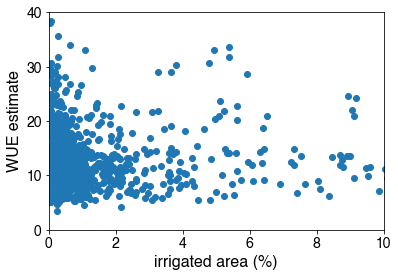

In [85]:
# plt.figure()
# plt.ylim([0, 40])
# plt.scatter(pa, wue)
# plt.xlabel('cropped area (%)')
# plt.ylabel('WUE estimate')

plt.figure
plt.xlim([0,10])
plt.ylim([0, 40])
plt.scatter(ir, wue)
plt.xlabel('irrigated area (%)')
plt.ylabel('WUE estimate')


nn = np.where((~np.isnan(ir)) & (ir > 1) & (~np.isnan(pa)) & (~np.isnan(wue)))[0]
# X = sm.add_constant(pa[nn])
# mdl = sm.OLS(wue[nn], X).fit()
# mdl.summary()


In [86]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
yieldMdlDeepak = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()

In [105]:
curCountyList = countyList.copy()

paMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizePlantedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

irThresh1 = 0
irThresh2 = 100
paThresh1 = 0
paThresh2 = 100
paIrInds = np.where((irAggAll >= irThresh1) & (irAggAll < irThresh2) & (paMeanAggAll >= paThresh1) & (paMeanAggAll < paThresh2))[0]

# paIrInds = [paIrInds[0]]

useDeepak = False

if useDeepak:
    countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak']))[paIrInds,:] 
    countyYield = np.array(list(curCountyList['maizeYieldDeepak']))[paIrInds,:] 
    countyYieldAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[paIrInds,:] 
else:
    countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMean']))[paIrInds,:] 
    countyYield = np.array(list(curCountyList['maizeYield']))[paIrInds,:] 
    countyYieldAnom = np.array(list(curCountyList['maizeYieldDetrend']))[paIrInds,:] 

countyPa = np.array([a for a in np.array(list(usCounties['maizePlantedAreaFraction']))[paIrInds,:]])*100
countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))[paIrInds]
countyState = np.array(list(usCounties['STATE']))[paIrInds]
countyFips = np.array(list(usCounties['FIPS']))[paIrInds]

countyPr = np.array(list(curCountyList['seasonalPrecip']))[paIrInds,:]
countyKdd = np.array(list(curCountyList['kdd']))[paIrInds,:]
countyGdd = np.array(list(curCountyList['gdd']))[paIrInds,:]
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))[paIrInds,:]/2.5e6*10000
countySshf = -np.array(list(curCountyList['seasonalSshf']))[paIrInds,:]/2.5e6*10000
countySsr = np.array(list(curCountyList['seasonalSsr']))[paIrInds,:]/2.5e6*10000
countyStr = np.array(list(curCountyList['seasonalStr']))[paIrInds,:]/2.5e6*10000
countyNetRad = (countySsr+countyStr)

NYears = countyKdd.shape[1]

countyU10 = np.array(list(curCountyList['seasonalU10']))[paIrInds,:]
countyV10 = np.array(list(curCountyList['seasonalV10']))[paIrInds,:]

lhTrendFrac = []
shTrendFrac = []
kddTrendFrac = []
kddFromFeedback = []
gddTrendFrac = []
gddFromFeedback = []
yieldTrendFrac = []
yieldChgFeedbackWithAgInt = []
yieldChgFeedbackWithoutAgInt = []

kddChgFeedbackWithAgInt = []
kddChgFeedbackWithoutAgInt = []
kddChgObs = []

countyWUE = []

yieldChgObs = []
yieldFromFeedback = []

fipsSel = []
paSel = []
irSel = []
stateSel = []

for i in range(len(paIrInds)):
    
    if i % 200 == 0:
        print('%d of %d'%(i, len(paIrInds)))
    
    if useDeepak:
        curYieldAreaAdjDetrend = countyYieldDetrend[i,:] * countyPa[i,:]/100
        curYieldDetrend = countyYieldDetrend[i,:]
        curYieldAreaAdjAnom = countyYieldAnom[i,:] * countyPa[i,:]/100
        curYieldAnom = countyYieldAnom[i,:]
        curYield = countyYield[i,:]
        curYieldAreaAdj = countyYield[i,:] * countyPa[i,:]/100 * .5 * 1000
    else:
        curYieldAreaAdjDetrend = countyYieldDetrend[i,:] * countyPa[i,:]/100
        curYieldDetrend = countyYieldDetrend[i,:]
        curYieldAreaAdjAnom = countyYieldAnom[i,:] * countyPa[i,:]/100
        curYieldAnom = countyYieldAnom[i,:]
        curYield = countyYield[i,:]
        curYieldAreaAdj = countyYield[i,:] * countyPa[i,:]/100 * .5 * 25.4 * 2.47
    
    curKdd = countyKdd[i,:]
    curGdd = countyGdd[i,:]
    curSshf = countySshf[i,:]
    curSlhf = countySlhf[i,:]
    curSsr = countySsr[i,:]
    curStr = countyStr[i,:]
    curU10 = countyU10[i,:]
    curV10 = countyV10[i,:]
    curPr = countyPr[i,:]

    nn = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                  (~np.isnan(curYield)) & (~np.isnan(curYieldAnom)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]

    stateSel.append(countyState[i])
    if len(nn) < 5:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        gddTrendFrac.append(np.nan)
        kddFromFeedback.append(np.nan)
        gddFromFeedback.append(np.nan)
        yieldFromFeedback.append(np.nan)
        yieldChgFeedbackWithAgInt.append(np.nan)
        yieldChgFeedbackWithoutAgInt.append(np.nan)
        yieldChgObs.append(np.nan)
        
        kddChgFeedbackWithAgInt.append(np.nan)
        kddChgFeedbackWithoutAgInt.append(np.nan)
        kddChgObs.append(np.nan)
        
        countyWUE.append(np.nan)
        
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    curKdd = curKdd[nn]
    curGdd = curGdd[nn]
    curSshf = curSshf[nn]
    curSlhf = curSlhf[nn]
    curSsr = curSsr[nn]
    curStr = curStr[nn]
    curU10 = curU10[nn]
    curV10 = curV10[nn]
    curPr = curPr[nn]
    curYieldAnom = curYieldAnom[nn]
    curYieldAreaAdjDetrend = curYieldAreaAdjDetrend[nn]
    curYieldDetrend = curYieldDetrend[nn]
    curYieldAreaAdjAnom = curYieldAreaAdjAnom[nn]
    curYield = curYield[nn]
    curYieldAreaAdj = curYieldAreaAdj[nn]

    
    data = {'KDD_Anom':curKdd-np.nanmean(curKdd), \
            'KDD':curKdd, \
            'GDD_Anom':curGdd-np.nanmean(curGdd), \
            'GDD':curGdd, \
            'SSHF_Anom':curSshf-np.nanmean(curSshf), \
            'SLHF_Anom':curSlhf-np.nanmean(curSlhf), \
            'SLHF':curSlhf, \
            'U10_Anom':curU10-np.nanmean(curU10), \
            'U10':curU10, \
            'V10_Anom':curV10-np.nanmean(curV10), \
            'V10':curV10, \
            'Pr_Anom':curPr-np.nanmean(curPr), \
            'Pr':curPr, \
            'NetRad_Anom':(curSsr+curStr)-np.nanmean(curSsr+curStr), \
            'NetRad':(curSsr+curStr), \
            'YieldAreaAdj_Detrend':curYieldAreaAdjDetrend, \
            'Yield_Detrend':curYieldDetrend, \
            'YieldAreaAdj_Anom':curYieldAreaAdjAnom, \
            'Yield_Anom':curYieldAnom, \
            'Yield':curYield, \
            'YieldAreaAdj':curYieldAreaAdj}

    df = pd.DataFrame(data, \
                      columns=['KDD_Anom', 'KDD', 'GDD_Anom', 'GDD', 'SLHF_Anom', 'SLHF', 'SSHF_Anom', 'NetRad_Anom', 'NetRad', \
                               'Pr_Anom', 'Pr', 'U10_Anom', 'U10', 'V10_Anom', 'V10', \
                               'Yield', 'YieldAreaAdj', 'Yield_Detrend', 'YieldAreaAdj_Anom', 'YieldAreaAdj_Detrend', 'Yield_Anom'])

    mdl_LH_Y = smf.ols(formula='SLHF_Anom ~ Yield_Anom + Pr_Anom + NetRad_Anom + U10_Anom + V10_Anom', data=df).fit()
    mdl_LH_Y_Abs = smf.ols(formula='SLHF ~ YieldAreaAdj + Pr + NetRad + U10 + V10', data=df).fit()
    
    if mdl_LH_Y.pvalues['Yield_Anom'] > 0.1:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        kddFromFeedback.append(np.nan)
        gddFromFeedback.append(np.nan)
        
        yieldChgFeedbackWithAgInt.append(np.nan)
        yieldChgFeedbackWithoutAgInt.append(np.nan)
        yieldChgObs.append(np.nan)
        
        kddChgFeedbackWithAgInt.append(np.nan)
        kddChgFeedbackWithoutAgInt.append(np.nan)
        kddChgObs.append(np.nan)
        
        countyWUE.append(np.nan)
        
        gddTrendFrac.append(np.nan)
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    countyWUE.append(mdl_LH_Y_Abs.params['YieldAreaAdj'])
    
    mdl_LH_SH = smf.ols(formula='SSHF_Anom ~ SLHF_Anom + NetRad_Anom', data=df).fit()
    mdl_SH_KDD = smf.ols(formula='KDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_SH_GDD = smf.ols(formula='GDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_KDD_GDD_PR_Yield = smf.ols(formula='Yield_Anom ~ GDD_Anom + KDD_Anom + Pr_Anom', data=df).fit()
    
    X = {'Yield_Anom':data['Yield'] - np.nanmean(data['Yield']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Trend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)

    X = {'Yield_Anom':data['Yield_Detrend'] - np.nanmean(data['Yield']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Detrend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)
    
    
    X = {'SLHF_Anom':lhMod_Trend-np.nanmean(lhMod_Trend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Trend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SLHF_Anom':lhMod_Detrend-np.nanmean(lhMod_Detrend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Detrend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SSHF_Anom':shMod_Trend-np.nanmean(shMod_Trend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Trend = mdl_SH_KDD.predict(X).values + np.nanmean(curKdd)
    kddMod_Trend[kddMod_Trend<0] = 0
    gddMod_Trend = mdl_SH_GDD.predict(X).values + np.nanmean(curGdd)
    gddMod_Trend[gddMod_Trend<0] = 0
    
    X = {'SSHF_Anom':shMod_Detrend-np.nanmean(shMod_Detrend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Detrend = mdl_SH_KDD.predict(X).values+np.nanmean(curKdd)
    kddMod_Detrend[kddMod_Detrend<0] = 0
    gddMod_Detrend = mdl_SH_GDD.predict(X).values+np.nanmean(curGdd)
    gddMod_Detrend[gddMod_Detrend<0] = 0
    
    
    X = {'GDD_Anom':gddMod_Trend-np.nanmean(gddMod_Trend),
         'GDD':gddMod_Trend,
         'KDD_Anom':kddMod_Trend-np.nanmean(kddMod_Trend), 
         'KDD':kddMod_Trend, 
         'Pr_Anom':data['Pr_Anom'], 
         'Pr':data['Pr']}
#     yieldMod_Trend = yieldMdlDeepak.predict(X).values+np.nanmean(curYield)
    yieldMod_Trend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    X = {'GDD_Anom':gddMod_Detrend-np.nanmean(gddMod_Detrend), 
         'GDD':gddMod_Detrend, 
         'KDD_Anom':kddMod_Detrend-np.nanmean(kddMod_Detrend), 
         'KDD':kddMod_Detrend, 
         'Pr_Anom':data['Pr_Anom'], 
         'Pr':data['Pr']}
#     yieldMod_Detrend = yieldMdlDeepak.predict(X).values+np.nanmean(curYield)
    yieldMod_Detrend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    
    # SH
    X = sm.add_constant(range(len(shMod_Trend)))
    mdl = sm.OLS(shMod_Trend, X).fit()
    shModTrend_yieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(shMod_Detrend)))
    mdl = sm.OLS(shMod_Detrend, X).fit()
    shModTrend_noYieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curSshf)))
    mdl = sm.OLS(curSshf, X).fit()
    curSshfTrend = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    shTrendFrac.append(((shModTrend_yieldGrowth[-1] - shModTrend_yieldGrowth[0]) - \
                       (shModTrend_noYieldGrowth[-1] - shModTrend_noYieldGrowth[0])) / \
                       (curSshfTrend[-1] - curSshfTrend[0]))
    
    # LH
    X = sm.add_constant(range(len(lhMod_Trend)))
    mdl = sm.OLS(lhMod_Trend, X).fit()
    lhModTrend_yieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(lhMod_Detrend)))
    mdl = sm.OLS(lhMod_Detrend, X).fit()
    lhModTrend_noYieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curSlhf)))
    mdl = sm.OLS(curSlhf, X).fit()
    curSlhfTrend = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    lhTrendFrac.append(((lhModTrend_yieldGrowth[-1] - lhModTrend_yieldGrowth[0]) - \
                       (lhModTrend_noYieldGrowth[-1] - lhModTrend_noYieldGrowth[0])) / \
                       (curSlhfTrend[-1] - curSlhfTrend[0]))
    
    # KDD
    X = sm.add_constant(range(len(kddMod_Trend)))
    mdl = sm.OLS(kddMod_Trend, X).fit()
    kddModTrend_yieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(kddMod_Detrend)))
    mdl = sm.OLS(kddMod_Detrend, X).fit()
    kddModTrend_noYieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curKdd)))
    mdl = sm.OLS(curKdd, X).fit()
    curKddTrend = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    kddTrendFrac.append(((kddModTrend_yieldGrowth[-1] - kddModTrend_yieldGrowth[0]) - \
                       (kddModTrend_noYieldGrowth[-1] - kddModTrend_noYieldGrowth[0])) / \
                       (curKddTrend[-1] - curKddTrend[0]))
    kddFromFeedback.append(((kddModTrend_yieldGrowth[-1] - kddModTrend_yieldGrowth[0]) - \
                       (kddModTrend_noYieldGrowth[-1] - kddModTrend_noYieldGrowth[0])))
    
    kddChgFeedbackWithAgInt.append(kddModTrend_yieldGrowth[-1] - kddModTrend_yieldGrowth[0])
    kddChgFeedbackWithoutAgInt.append(kddModTrend_noYieldGrowth[-1] - kddModTrend_noYieldGrowth[0])
    kddChgObs.append(curKddTrend[-1] - curKddTrend[0])
    
    
    
    # GDD
    X = sm.add_constant(range(len(gddMod_Trend)))
    mdl = sm.OLS(gddMod_Trend, X).fit()
    gddModTrend_yieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(gddMod_Detrend)))
    mdl = sm.OLS(gddMod_Detrend, X).fit()
    gddModTrend_noYieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curGdd)))
    mdl = sm.OLS(curGdd, X).fit()
    curGddTrend = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    gddTrendFrac.append(((gddModTrend_yieldGrowth[-1] - gddModTrend_yieldGrowth[0]) - \
                       (gddModTrend_noYieldGrowth[-1] - gddModTrend_noYieldGrowth[0])) / \
                       (curGddTrend[-1] - curGddTrend[0]))
    gddFromFeedback.append(((gddModTrend_yieldGrowth[-1] - gddModTrend_yieldGrowth[0]) - \
                       (gddModTrend_noYieldGrowth[-1] - gddModTrend_noYieldGrowth[0])))
    
    
    
    # Yield
    X = sm.add_constant(range(len(yieldMod_Trend)))
    mdl = sm.OLS(yieldMod_Trend, X).fit()
    yieldModTrend_yieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(yieldMod_Detrend)))
    mdl = sm.OLS(yieldMod_Detrend, X).fit()
    yieldModTrend_noYieldGrowth = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curYield)))
    mdl = sm.OLS(curYield, X).fit()
    curYieldTrend = mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    yieldTrendFrac.append(((yieldModTrend_yieldGrowth[-1] - yieldModTrend_yieldGrowth[0]) - 
                       (yieldModTrend_noYieldGrowth[-1] - yieldModTrend_noYieldGrowth[0])) / 
                       (curYieldTrend[-1] - curYieldTrend[0]))
    
    yieldFromFeedback.append(((yieldModTrend_yieldGrowth[-1] - yieldModTrend_yieldGrowth[0]) - 
                       (yieldModTrend_noYieldGrowth[-1] - yieldModTrend_noYieldGrowth[0])))
        
    yieldChgFeedbackWithAgInt.append(yieldModTrend_yieldGrowth[-1] - yieldModTrend_yieldGrowth[0])
    yieldChgFeedbackWithoutAgInt.append(yieldModTrend_noYieldGrowth[-1] - yieldModTrend_noYieldGrowth[0])
    yieldChgObs.append(curYieldTrend[-1] - curYieldTrend[0])
    
    paSel.append(np.nanmean(countyPa[i,:]))
    irSel.append(countyIr[i])
    fipsSel.append(countyFips[i])
    
fipsSel = np.array(fipsSel)
paSel = np.array(paSel)
irSel = np.array(irSel)
lhTrendFrac = np.array(lhTrendFrac)*100
shTrendFrac = np.array(shTrendFrac)*100
kddTrendFrac = np.array(kddTrendFrac)*100
kddFromFeedback = np.array(kddFromFeedback)
gddTrendFrac = np.array(gddTrendFrac)*100
gddFromFeedback = np.array(gddFromFeedback)
yieldTrendFrac = np.array(yieldTrendFrac)*100
yieldChgFeedbackWithAgInt = np.array(yieldChgFeedbackWithAgInt)
yieldChgFeedbackWithoutAgInt = np.array(yieldChgFeedbackWithoutAgInt)
yieldChgObs = np.array(yieldChgObs)

countyWUE = np.array(countyWUE)

kddChgFeedbackWithAgInt = np.array(kddChgFeedbackWithAgInt)
kddChgFeedbackWithoutAgInt = np.array(kddChgFeedbackWithoutAgInt)
kddChgObs = np.array(kddChgObs)

0 of 2248
200 of 2248
400 of 2248
600 of 2248
800 of 2248
1000 of 2248
1200 of 2248
1400 of 2248
1600 of 2248
1800 of 2248
2000 of 2248
2200 of 2248


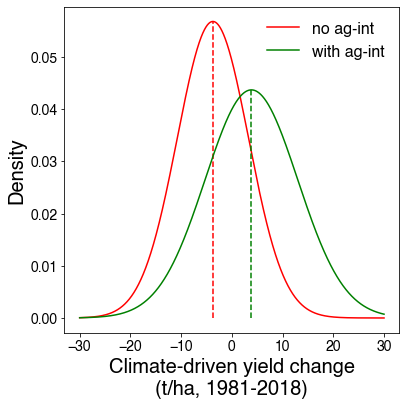

In [109]:
from scipy.stats import norm

nnAgInt = np.where(~np.isnan(yieldChgFeedbackWithAgInt))[0]
nnNoAgInt = np.where(~np.isnan(yieldChgFeedbackWithoutAgInt))[0]

normAgInt = norm.fit(yieldChgFeedbackWithAgInt[nnAgInt])
normNoAgInt = norm.fit(yieldChgFeedbackWithoutAgInt[nnNoAgInt])

if useDeepak:
    xaxis = np.arange(-2, 2, 0.01)
else:
    xaxis = np.arange(-30, 30, 0.01)
pdfAgInt = norm.pdf(xaxis, normAgInt[0], normAgInt[1])
pdfNoAgInt = norm.pdf(xaxis, normNoAgInt[0], normNoAgInt[1])

xMaxAgInt = np.where(pdfAgInt==np.nanmax(pdfAgInt))[0]
xMaxNoAgInt = np.where(pdfNoAgInt==np.nanmax(pdfNoAgInt))[0]

plt.figure(figsize=(6,6))
plt.plot(xaxis, pdfNoAgInt, '-r', label='no ag-int')
plt.plot([xaxis[xMaxNoAgInt], xaxis[xMaxNoAgInt]], [0, pdfNoAgInt[xMaxNoAgInt]], '--r')

plt.plot(xaxis, pdfAgInt, '-g', label='with ag-int')
plt.plot([xaxis[xMaxAgInt], xaxis[xMaxAgInt]], [0, pdfAgInt[xMaxAgInt]], '--g')

if useDeepak:
    plt.xlabel('Climate-driven yield change\n(t/ha, 1981-2018)', fontsize=20)
else:
    plt.xlabel('Climate-driven yield change\n(kg/ha, 1981-2018)', fontsize=20)
plt.ylabel('Density', fontsize=20)
# plt.yticks(np.arange(0, 1.3, .2), fontsize=20)
# plt.xticks(np.arange(-2, 2.1, 1), fontsize=20)

leg = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc = 'upper right')
leg.get_frame().set_linewidth(0.0)
# plt.savefig('plant-age-comparison-%s-%s.png'%(tempVar, qsVar), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [90]:
# fracLevel = 500

# lhTrendFrac[abs(lhTrendFrac) > fracLevel] = np.nan
# shTrendFrac[abs(shTrendFrac) > fracLevel] = np.nan
# kddTrendFrac[abs(kddTrendFrac) > fracLevel] = np.nan
# gddTrendFrac[abs(gddTrendFrac) > fracLevel] = np.nan
# yieldTrendFrac[abs(yieldTrendFrac) > fracLevel] = np.nan

In [125]:
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])
gddTrendAll = np.array([a for a in usCounties['gddTrend']])
if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
else:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
prodTrendAll = np.array([yieldTrendAll[i]*paSel[i] for i in range(len(yieldTrendAll))])
slhfTrendAll = np.array([a for a in usCounties['seasonalSlhfTrend']])
nn = np.where((~np.isnan(irAggAll)) & (~np.isnan(kddTrendAll)) & (~np.isnan(slhfTrendAll)) & \
               (~np.isnan(yieldTrendAll)) & (~np.isnan(yieldTrendFrac)) & (~np.isnan(meanYieldAll)))[0]

X = sm.add_constant(irAggAll[nn])
mdlIrKdd = sm.OLS(kddTrendAll[nn], X).fit()

X = sm.add_constant(irAggAll[nn])
mdlIrYield = sm.OLS(yieldTrendAll[nn], X).fit()

X = sm.add_constant(np.array([irAggAll[nn], kddTrendAll[nn]]).T)
mdlIrKddYield = sm.OLS(yieldTrendAll[nn], X).fit()
# mdlIrKddYield.summary()

(-5, 45)

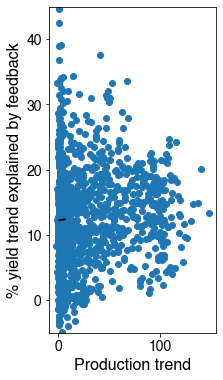

In [126]:
x1 = 0
x2 = 8
X = sm.add_constant(prodTrendAll[nn])
mdl = sm.OLS(yieldTrendFrac[nn], X).fit()

plt.figure(figsize=(3,6))
plt.scatter(prodTrendAll[nn], yieldTrendFrac[nn])
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.xlabel('Production trend')
plt.ylabel('% yield trend explained by feedback')
plt.ylim([-5, 45])


Text(0, 0.5, 'Yield trend')

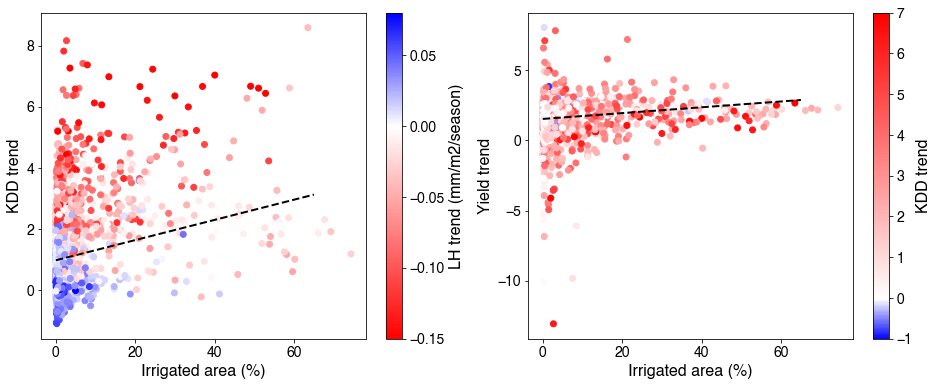

In [127]:
x1 = 0
x2 = 65
midnorm = MidpointNormalize(vmin=-.15, vcenter=0, vmax=.08)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
a = ax1.scatter(irAggAll,kddTrendAll,c=-slhfTrendAll/2.5e6, cmap='bwr_r', norm=midnorm)
ax1.plot([x1, x2], [mdlIrKdd.params[0]+x1*mdlIrKdd.params[1], mdlIrKdd.params[0]+x2*mdlIrKdd.params[1]], '--k', lw=2)
cbar = fig.colorbar(a, ax=ax1)
cbar.set_label('LH trend (mm/m2/season)')
ax1.set_xlabel('Irrigated area (%)')
ax1.set_ylabel('KDD trend')

midnorm = MidpointNormalize(vmin=-1, vcenter=0, vmax=7)

a = ax2.scatter(irAggAll,yieldTrendAll,c=kddTrendAll, cmap='bwr', norm=midnorm)
ax2.plot([x1, x2], [mdlIrYield.params[0]+x1*mdlIrYield.params[1], mdlIrYield.params[0]+x2*mdlIrYield.params[1]], '--k', lw=2)
cbar = fig.colorbar(a, ax=ax2)
cbar.set_label('KDD trend')
ax2.set_xlabel('Irrigated area (%)')
ax2.set_ylabel('Yield trend')

# plt.savefig('kdd-trend-ir-slhf-trend.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

In [128]:
inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
np.nanmean(yieldTrendFrac[inds])

13.571696020183992

In [129]:
np.nanmean(yieldTrendFrac)

12.839867295220888

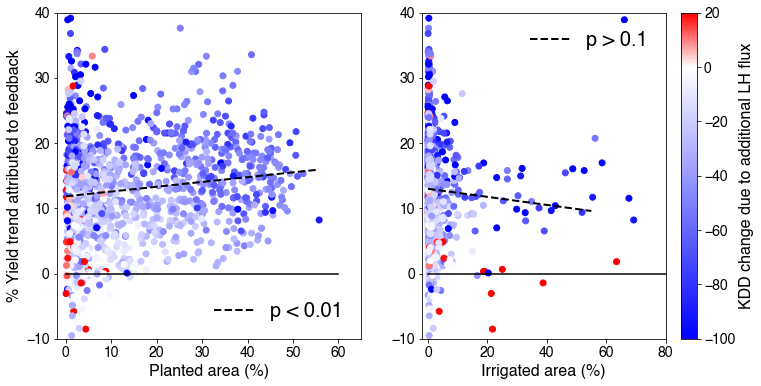

In [130]:
nn = np.where((~np.isnan(paSel)) & (~np.isnan(yieldTrendFrac)) & (~np.isnan(irSel)))
X = sm.add_constant(irSel[nn])
mdlIr = sm.OLS(yieldTrendFrac[nn], X).fit()

X = sm.add_constant(paSel[nn])
mdlPa = sm.OLS(yieldTrendFrac[nn], X).fit()

x1 = 0
x2 = 55

midnorm = MidpointNormalize(vmin=-100, vcenter=0, vmax=20)
cmap = plt.cm.get_cmap('bwr')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax1.scatter(paSel, yieldTrendFrac, c=kddFromFeedback, cmap=cmap, norm=midnorm)
ax1.plot([x1, x2], [mdlPa.params[0]+x1*mdlPa.params[1], mdlPa.params[0]+x2*mdlPa.params[1]], '--k', lw=2, label='p < 0.01')
ax1.plot([0, 60], [0, 0], '-k')
ax1.set_xlabel('Planted area (%)')
ax1.set_ylabel('% Yield trend attributed to feedback')
ax1.set_xlim([-2, 65])
ax1.set_ylim([-10, 40])
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

a = ax2.scatter(irSel, yieldTrendFrac, c=kddFromFeedback, cmap=cmap, norm=midnorm)
ax2.plot([x1, x2], [mdlIr.params[0]+x1*mdlIr.params[1], mdlIr.params[0]+x2*mdlIr.params[1]], '--k', lw=2, label='p > 0.1')
ax2.plot([0, 80], [0, 0], '-k')
ax2.set_xlabel('Irrigated area (%)')
ax2.set_xlim([-2, 80])
ax2.set_ylim([-10, 40])
l1 = ax2.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
cbar = fig.colorbar(a, ax=ax2)#, ticks=np.linspace(0,1,9))
cbar.set_label('KDD change due to additional LH flux')
# cbar.ax.set_yticklabels(np.arange(-80,81,20))

# plt.savefig('yield-trend-due-to-lh-flux.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

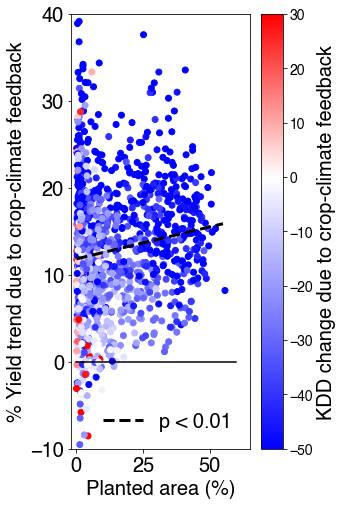

In [131]:
midnorm = MidpointNormalize(vmin=-50, vcenter=0, vmax=30)

plt.figure(figsize=(4,8))
a = plt.scatter(paSel, yieldTrendFrac, c=kddFromFeedback, cmap=cmap, norm=midnorm)
plt.plot([x1, x2], [mdlPa.params[0]+x1*mdlPa.params[1], mdlPa.params[0]+x2*mdlPa.params[1]], '--k', lw=3, label='p < 0.01')
plt.plot([0, 60], [0, 0], '-k')
plt.xlabel('Planted area (%)', fontsize=20)
plt.ylabel('% Yield trend due to crop-climate feedback', fontsize=20)
plt.xticks([0, 25, 50])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim([-2, 65])
plt.ylim([-10, 40])
cbar = plt.colorbar(a)#ticks=np.linspace(0,1,9))
cbar.set_label('KDD change due to crop-climate feedback', fontsize=20)
# cbar.ax.set_yticklabels(np.arange(-80,81,20))
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

# plt.savefig('yield-trend-due-to-lh-flux-pa.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

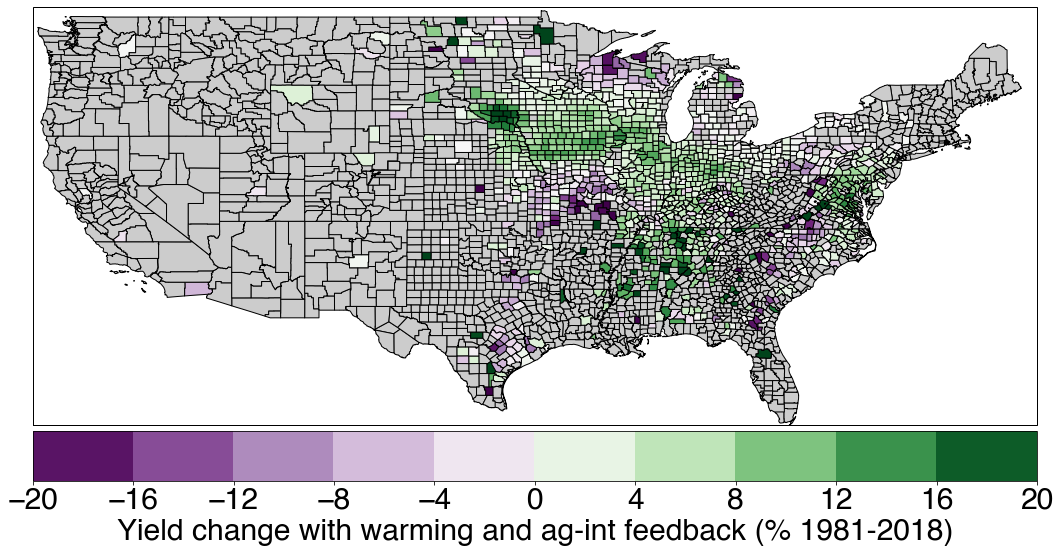

In [132]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

showPct = True

if showPct:
    v1 = -20
    v2 = 20
else:
    v1 = -1
    v2 = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = yieldChgFeedbackWithAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = yieldChgFeedbackWithAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
if showPct:
    cb = plt.colorbar(scmap, ticks=np.arange(-20, 21, 4), 
                 boundaries=np.arange(-20, 21, 4), orientation='horizontal',
                 pad=0.01)
else:
    cb = plt.colorbar(scmap, ticks=np.arange(-1, 1.1, .25), 
             boundaries=np.arange(-1, 1.1, .25), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Yield change with warming and ag-int feedback (% 1981-2018)', fontsize=mapFontSize)
else:
    cb.set_label('Yield change with warming and ag-int feedback (t/ha, 1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

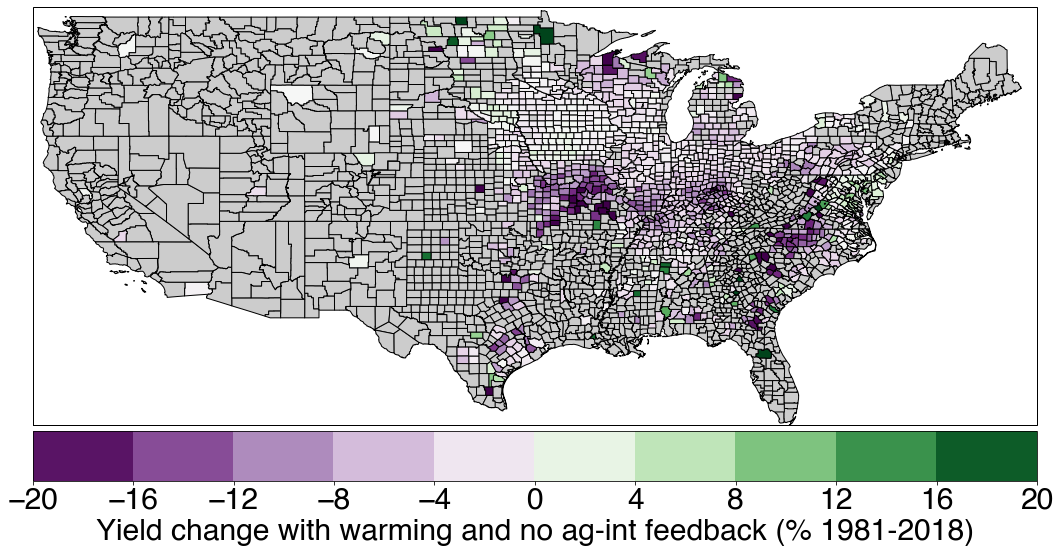

In [134]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

showPct = True

if showPct:
    v1 = -20
    v2 = 20
else:
    v1 = -1
    v2 = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = yieldChgFeedbackWithoutAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = yieldChgFeedbackWithoutAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
if showPct:
    cb = plt.colorbar(scmap, ticks=np.arange(-20, 21, 4), 
                 boundaries=np.arange(-20, 21, 4), orientation='horizontal',
                 pad=0.01)
else:
    cb = plt.colorbar(scmap, ticks=np.arange(-1, 1.1, .25), 
             boundaries=np.arange(-1, 1.1, .25), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Yield change with warming and no ag-int feedback (% 1981-2018)', fontsize=mapFontSize)
else:
    cb.set_label('Yield change with warming and no ag-int feedback (t/ha, 1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

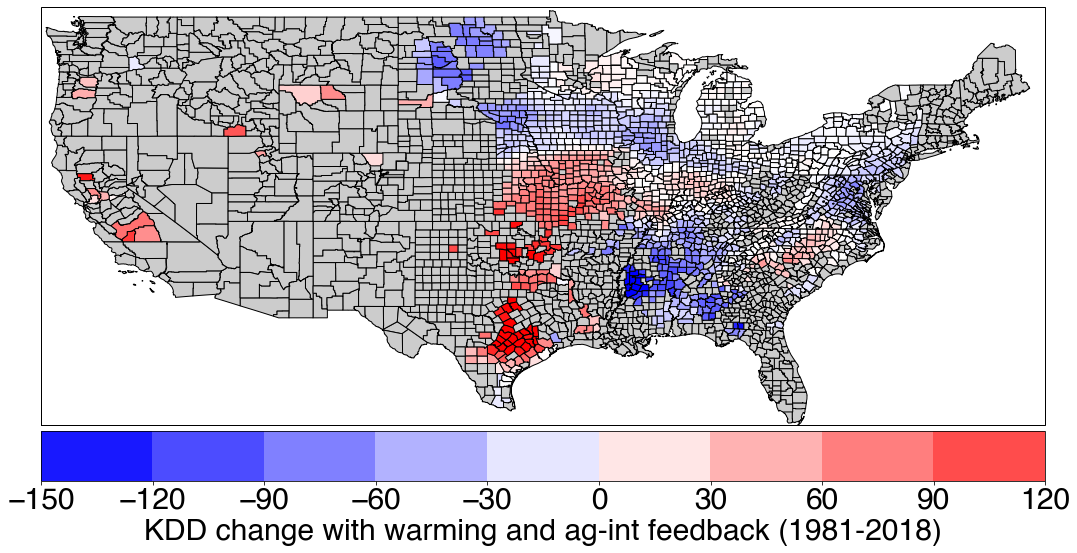

In [100]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

v1 = -150
v2 = 150

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = kddChgFeedbackWithAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, 30), 
             boundaries=np.arange(v1, v2, 30), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD change with warming and ag-int feedback (1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

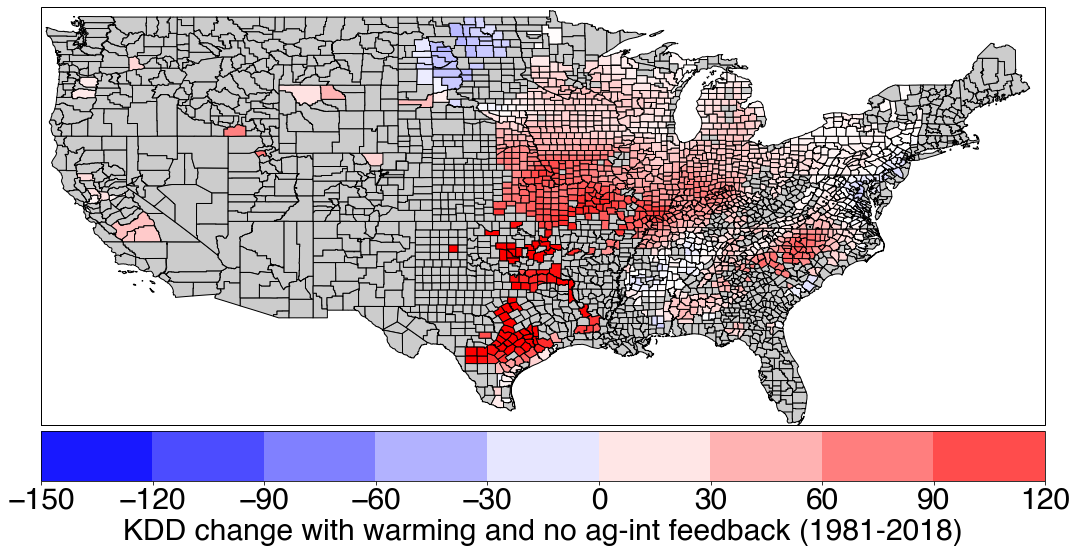

In [101]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

v1 = -150
v2 = 150

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = kddChgFeedbackWithoutAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, 30), 
             boundaries=np.arange(v1, v2, 30), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD change with warming and no ag-int feedback (1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

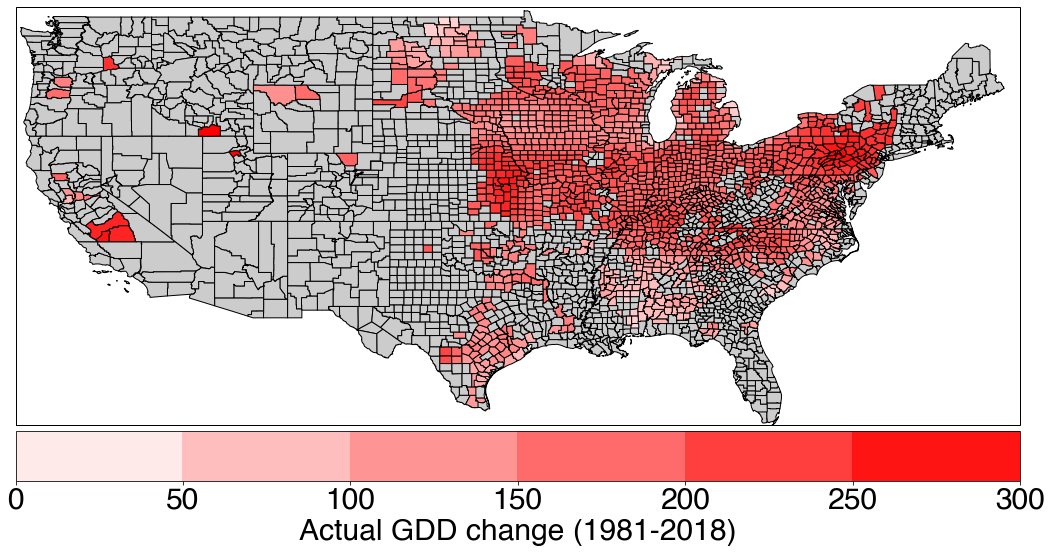

In [102]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

v1 = -0
v2 = 300

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = gddTrendAll[ind[0]]*NYears
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(0, 301, 50),
             boundaries=np.arange(0, 301, 50), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Actual GDD change (1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

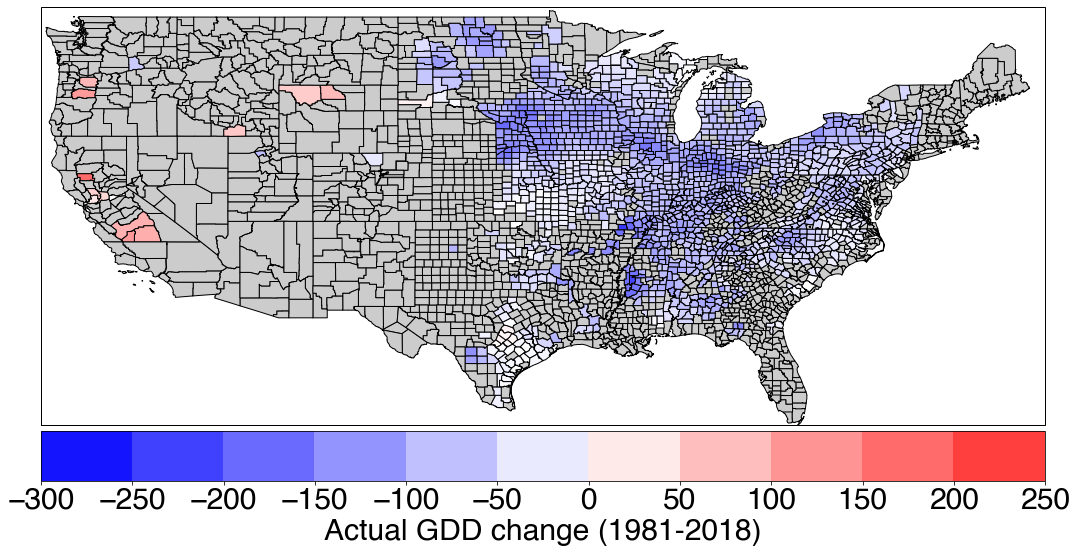

In [103]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

v1 = -300
v2 = 300

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = gddFromFeedback[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, 50),
             boundaries=np.arange(v1, v2, 50), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Actual GDD change (1981-2018)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

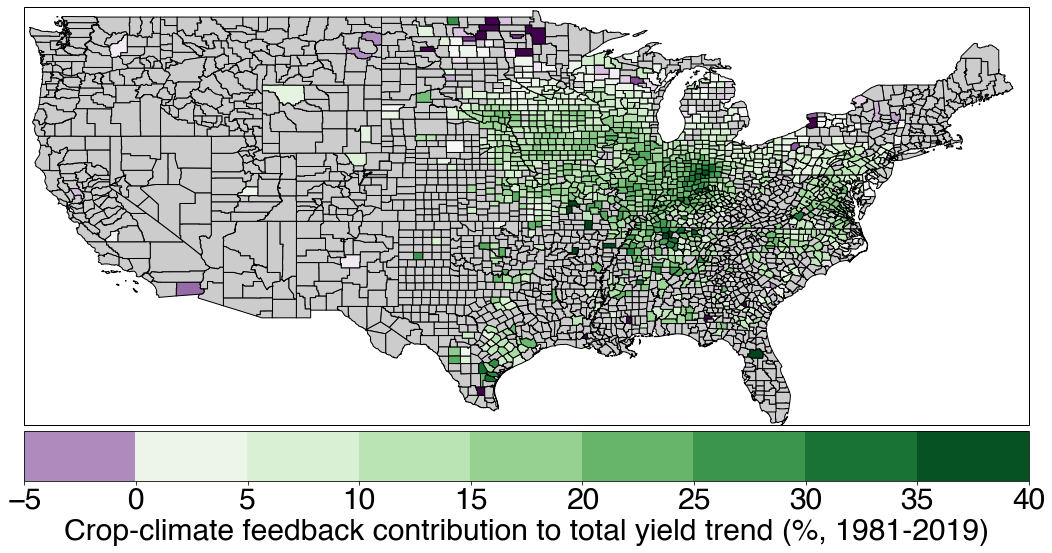

In [135]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

midnorm = MidpointNormalize(vmin=-5, vcenter=0, vmax=40)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curYieldTrendFrac = yieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-5,41,5), 
             boundaries=np.arange(-5,41,5), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Crop-climate feedback contribution to total yield trend (%, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-yield-trend-frac-feedback.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

Text(0, 0.5, 'Yield')

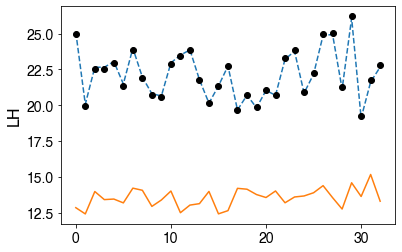

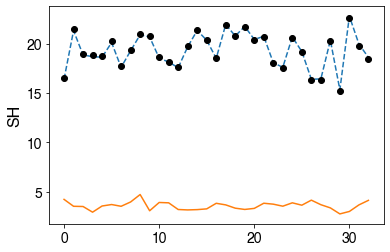

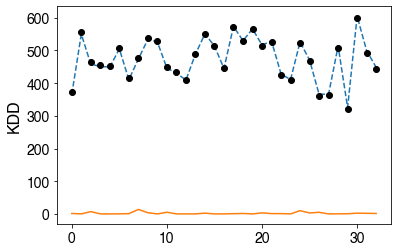

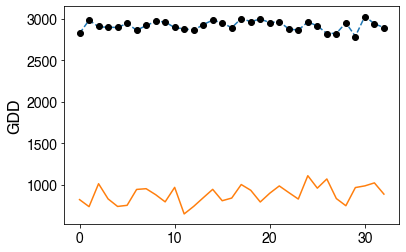

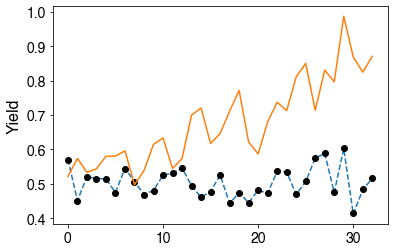

In [180]:
plt.figure()
plt.plot(lhMod_Detrend, '--')
plt.plot(lhMod_Trend, 'ko')
plt.plot(curSlhf, '-')
plt.ylabel('LH')

plt.figure()
plt.plot(shMod_Detrend, '--')
plt.plot(shMod_Trend, 'ko')
plt.plot(curSshf, '-')
plt.ylabel('SH')

plt.figure()
plt.plot(kddMod_Detrend, '--')
plt.plot(kddMod_Trend, 'ko')
plt.plot(curKdd, '-')
plt.ylabel('KDD')

plt.figure()
plt.plot(gddMod_Detrend, '--')
plt.plot(gddMod_Trend, 'ko')
plt.plot(curGdd, '-')
plt.ylabel('GDD')

plt.figure()
plt.plot(yieldMod_Detrend, '--')
plt.plot(yieldMod_Trend, 'ko')
plt.plot(curYield, '-')
plt.ylabel('Yield')

In [181]:
curCountyList = countyList.copy()

paMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizePlantedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

irThresh1 = 0
irThresh2 = 100
paThresh1 = 0
paThresh2 = 100
paIrInds = np.where((irAggAll >= irThresh1) & (irAggAll < irThresh2) & (paMeanAggAll >= paThresh1) & (paMeanAggAll < paThresh2))[0]


countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak']))[paIrInds,:] * 1000/10000
countyYieldAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[paIrInds,:] * 1000/10000
countyPa = np.array([a for a in np.array(list(usCounties['maizePlantedAreaFraction']))[paIrInds,:]])*100
countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))[paIrInds]
countyState = np.array(list(usCounties['STATE']))[paIrInds]
countyFips = np.array(list(usCounties['FIPS']))[paIrInds]

countyPr = np.array(list(curCountyList['seasonalPrecip']))[paIrInds,:]
countyKdd = np.array(list(curCountyList['kdd']))[paIrInds,:]
countyGdd = np.array(list(curCountyList['gdd']))[paIrInds,:]
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))[paIrInds,:]/2.5e6
countySshf = -np.array(list(curCountyList['seasonalSshf']))[paIrInds,:]/2.5e6
countySsr = np.array(list(curCountyList['seasonalSsr']))[paIrInds,:]/2.5e6
countyStr = np.array(list(curCountyList['seasonalStr']))[paIrInds,:]/2.5e6
countyNetRad = (countySsr+countyStr)

countyU10 = np.array(list(curCountyList['seasonalU10']))[paIrInds,:]
countyV10 = np.array(list(curCountyList['seasonalV10']))[paIrInds,:]

lhTrendFrac = []
shTrendFrac = []
kddTrendFrac = []
gddTrendFrac = []
yieldTrendFrac = []

fipsSel = []
paSel = []
irSel = []
stateSel = []

for i in range(len(paIrInds)):
    
    curYieldAreaAdjDetrend = countyYieldDetrend[i,:] * countyPa[i,:]/100
    curYieldDetrend = countyYieldDetrend[i,:]
    curYieldAreaAdjAnom = countyYieldAnom[i,:] * countyPa[i,:]/100
    curYieldAnom = countyYieldAnom[i,:]
    
    curYieldTestTrend = countyYieldDetrend[i,:].copy()
    curYieldTestTrend += np.array([0.01*k for k in range(len(curYieldTestTrend))])
    
    curKdd = countyKdd[i,:]
    curGdd = countyGdd[i,:]
    curSshf = countySshf[i,:]
    curSlhf = countySlhf[i,:]
    curSsr = countySsr[i,:]
    curStr = countyStr[i,:]
    curU10 = countyU10[i,:]
    curV10 = countyV10[i,:]
    curPr = countyPr[i,:]

    nn = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                  (~np.isnan(curYieldTestTrend)) & (~np.isnan(curYieldAnom)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]

    stateSel.append(countyState[i])
    if len(nn) < 5:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        gddTrendFrac.append(np.nan)
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    curKdd = curKdd[nn]
    curGdd = curGdd[nn]
    curSshf = curSshf[nn]
    curSlhf = curSlhf[nn]
    curSsr = curSsr[nn]
    curStr = curStr[nn]
    curU10 = curU10[nn]
    curV10 = curV10[nn]
    curPr = curPr[nn]
    curYieldAnom = curYieldAnom[nn]
    curYieldAreaAdjDetrend = curYieldAreaAdjDetrend[nn]
    curYieldDetrend = curYieldDetrend[nn]
    curYieldAreaAdjAnom = curYieldAreaAdjAnom[nn]
    curYieldTestTrend = curYieldTestTrend[nn]

    data = {'KDD_Anom':curKdd-np.nanmean(curKdd), \
            'GDD_Anom':curGdd-np.nanmean(curGdd), \
            'SSHF_Anom':curSshf-np.nanmean(curSshf), \
            'SLHF_Anom':curSlhf-np.nanmean(curSlhf), \
            'U10_Anom':curU10-np.nanmean(curU10), \
            'V10_Anom':curV10-np.nanmean(curV10), \
            'Pr_Anom':curPr-np.nanmean(curPr), \
            'NetRad_Anom':(curSsr+curStr)-np.nanmean(curSsr+curStr), \
            'YieldAreaAdj_Detrend':curYieldAreaAdjDetrend, \
            'Yield_Detrend':curYieldDetrend, \
            'YieldAreaAdj_Anom':curYieldAreaAdjAnom, \
            'Yield_Anom':curYieldAnom, \
            'Yield_TestTrend':curYieldTestTrend}

    df = pd.DataFrame(data, \
                      columns=['KDD_Anom', 'GDD_Anom', 'SLHF_Anom', 'SSHF_Anom', 'NetRad_Anom', 'Pr_Anom', 'U10_Anom', 'V10_Anom', \
                               'Yield_TestTrend', 'Yield_Detrend', 'YieldAreaAdj_Anom', 'YieldAreaAdj_Detrend', 'Yield_Anom'])

    mdl_LH_Y = smf.ols(formula='SLHF_Anom ~ Yield_Anom + Pr_Anom + NetRad_Anom + U10_Anom + V10_Anom', data=df).fit()
    
    if mdl_LH_Y.pvalues['Yield_Anom'] > 0.05:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        gddTrendFrac.append(np.nan)
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    mdl_LH_SH = smf.ols(formula='SSHF_Anom ~ SLHF_Anom', data=df).fit()
    mdl_SH_KDD = smf.ols(formula='KDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_SH_GDD = smf.ols(formula='GDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_KDD_GDD_PR_Yield = smf.ols(formula='Yield_Anom ~ GDD_Anom + KDD_Anom + Pr_Anom', data=df).fit()

    X = {'Yield_Anom':data['Yield_TestTrend'] - np.nanmean(data['Yield_TestTrend']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Trend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)

    X = {'Yield_Anom':data['Yield_Detrend'] - np.nanmean(data['Yield_TestTrend']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Detrend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)
    
    
    X = {'SLHF_Anom':lhMod_Trend-np.nanmean(lhMod_Trend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Trend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SLHF_Anom':lhMod_Detrend-np.nanmean(lhMod_Detrend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Detrend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SSHF_Anom':shMod_Trend-np.nanmean(shMod_Trend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Trend = mdl_SH_KDD.predict(X).values + np.nanmean(curKdd)
    kddMod_Trend[kddMod_Trend<0] = 0
    gddMod_Trend = mdl_SH_GDD.predict(X).values + np.nanmean(curGdd)
    gddMod_Trend[gddMod_Trend<0] = 0
    
    X = {'SSHF_Anom':shMod_Detrend-np.nanmean(shMod_Detrend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Detrend = mdl_SH_KDD.predict(X).values+np.nanmean(curKdd)
    kddMod_Detrend[kddMod_Detrend<0] = 0
    gddMod_Detrend = mdl_SH_GDD.predict(X).values+np.nanmean(curGdd)
    gddMod_Detrend[gddMod_Detrend<0] = 0
    
    
    X = {'GDD_Anom':gddMod_Trend-np.nanmean(gddMod_Trend), 
         'KDD_Anom':kddMod_Trend-np.nanmean(kddMod_Trend), 
         'Pr_Anom':data['Pr_Anom']}
    yieldMod_Trend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    X = {'GDD_Anom':gddMod_Detrend-np.nanmean(gddMod_Detrend), 
         'KDD_Anom':kddMod_Detrend-np.nanmean(kddMod_Detrend), 
         'Pr_Anom':data['Pr_Anom']}
    yieldMod_Detrend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    
    N = 10
    shTrendFrac.append(((np.nanmean(shMod_Trend[-N:])-np.nanmean(shMod_Trend[0:N])) - \
                     (np.nanmean(shMod_Detrend[-N:])-np.nanmean(shMod_Detrend[0:N])))/ \
                     (np.nanmean(curSshf[-N:])-np.nanmean(curSshf[0:N]))*100)
    
    lhTrendFrac.append(((np.nanmean(lhMod_Trend[-N:])-np.nanmean(lhMod_Trend[0:N])) - \
                     (np.nanmean(lhMod_Detrend[-N:])-np.nanmean(lhMod_Detrend[0:N])))/ \
                     (np.nanmean(curSlhf[-N:])-np.nanmean(curSlhf[0:N]))*100)
    
    kddTrendFrac.append(((np.nanmean(kddMod_Trend[-N:])-np.nanmean(kddMod_Trend[0:N])) - \
                     (np.nanmean(kddMod_Detrend[-N:])-np.nanmean(kddMod_Detrend[0:N])))/ \
                     (np.nanmean(curKdd[-N:])-np.nanmean(curKdd[0:N]))*100)
    
    gddTrendFrac.append(((np.nanmean(gddMod_Trend[-N:])-np.nanmean(gddMod_Trend[0:N])) - \
                     (np.nanmean(gddMod_Detrend[-N:])-np.nanmean(gddMod_Detrend[0:N])))/ \
                     (np.nanmean(curGdd[-N:])-np.nanmean(curGdd[0:N]))*100)
    
    yieldTrendFrac.append(((np.nanmean(yieldMod_Trend[-N:])-np.nanmean(yieldMod_Trend[0:N])) - \
                     (np.nanmean(yieldMod_Detrend[-N:])-np.nanmean(yieldMod_Detrend[0:N])))/ \
                     (np.nanmean(curYield[-N:])-np.nanmean(curYield[0:N]))*100)
    
    paSel.append(np.nanmean(countyPa[i,:]))
    irSel.append(countyIr[i])
    fipsSel.append(countyFips[i])
    
fipsSel = np.array(fipsSel)
paSel = np.array(paSel)
irSel = np.array(irSel)
lhTrendFrac = np.array(lhTrendFrac)
shTrendFrac = np.array(shTrendFrac)
kddTrendFrac = np.array(kddTrendFrac)
gddTrendFrac = np.array(gddTrendFrac)
yieldTrendFrac = np.array(yieldTrendFrac)

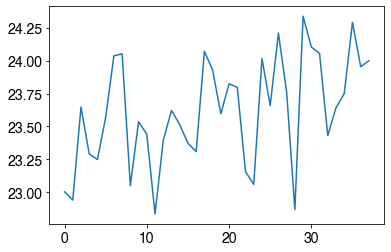

In [182]:
plt.plot(np.nanmean(countyNetRad,axis=0))

In [183]:
np.nanmean(yieldTrendFrac)

13.391634681983858

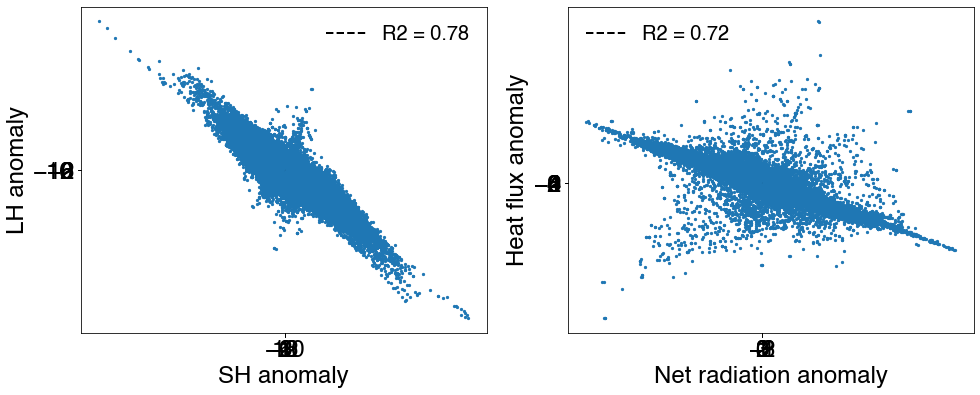

In [184]:
X = sm.add_constant(sshfAnomAgg)
mdl = sm.OLS(slhfAnomAgg, X).fit()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.scatter(-sshfAnomAgg, -slhfAnomAgg, s=5)
ax1.plot([-10,10], [10, -10], '--k', lw=2, label='R2 = %.2f'%(mdl.rsquared))
ax1.set_xlabel('SH anomaly', fontsize=24)
ax1.set_ylabel('LH anomaly', fontsize=24)
ax1.set_xticks(np.arange(-10, 11, 4))
ax1.set_yticks(np.arange(-10, 11, 4))
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
leg = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
leg.get_frame().set_linewidth(0)

X = sm.add_constant(-(ssrAnomAgg+strAnomAgg))
mdl = sm.OLS(-(sshfAnomAgg+slhfAnomAgg), X).fit()

ax2.scatter(-(ssrAnomAgg+strAnomAgg), -(sshfAnomAgg+slhfAnomAgg), s=5)
ax2.plot([-2.5,2.5], [2.5, -2.5], '--k', lw=2, label='R2 = %.2f'%(mdl.rsquared))
ax2.set_xlabel('Net radiation anomaly', fontsize=24)
ax2.set_ylabel('Heat flux anomaly', fontsize=24)
ax2.set_xticks(np.arange(-3, 4, 1))
ax2.set_yticks(np.arange(-6, 7, 2))
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)
leg = ax2.legend(prop = {'size':20, 'family':'Helvetica'})
leg.get_frame().set_linewidth(0)

plt.savefig('sh-vs-lh-us-counties.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = .1)

In [185]:
curCountyList = countyList.copy()

pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
pa = np.nanmean(pa,axis=1)*100
yieldVar = np.array([np.nanstd(x) for x in np.array(list(curCountyList['maizeYieldDetrendNorm']))])

irThresh = 0
paThresh = 0

paIrInds = np.where((ir>irThresh) & (pa>paThresh))[0]

kddTrendAgg = np.array([x for x in np.array(list(curCountyList['kddTrend']))[paIrInds]])
gddTrendAgg = np.array([x for x in np.array(list(curCountyList['gddTrend']))[paIrInds]])
prTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalPrecipTrend']))[paIrInds]])
sshfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSshfTrend']))[paIrInds]])
slhfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSlhfTrend']))[paIrInds]])
yieldTrendAgg = np.array([x for x in np.array(list(curCountyList['maizeYieldTrendDeepak']))[paIrInds]])
countyFE = np.array([c for c in paIrInds])


yieldTrendAgg *= 1000 / 10000
for i,p in enumerate(paIrInds):
    yieldTrendAgg[i] *= pa[p]/100
    
# convert from J/m2/growing season to mm/m2/growing season
sshfTrendAgg /= (2.5e6)
slhfTrendAgg /= (2.5e6)

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(gddTrendAgg)) & (~np.isnan(prTrendAgg)) & \
              (~np.isnan(sshfTrendAgg)) & (~np.isnan(slhfTrendAgg)) & (~np.isnan(yieldTrendAgg)))[0]

kddTrendAgg = kddTrendAgg[nn]
gddTrendAgg = gddTrendAgg[nn]
sshfTrendAgg = sshfTrendAgg[nn]
slhfTrendAgg = slhfTrendAgg[nn]
prTrendAgg = prTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
countyFE = countyFE[nn]

data = {'KDD':kddTrendAgg, \
        'GDD':gddTrendAgg, \
        'SSHF':-sshfTrendAgg, \
        'SLHF':-slhfTrendAgg, \
        'HF_TOT':-(sshfTrendAgg+slhfTrendAgg), \
        'Pr':prTrendAgg, \
        'Yield':yieldTrendAgg, \
        'CountyFE':countyFE}

df = pd.DataFrame(data, \
                  columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'HF_TOT', 'Pr', \
                           'Yield', 'CountyFE'])
mdl1 = smf.ols(formula='SLHF ~ Yield+Pr', data=df).fit()
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     864.5
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          6.51e-279
Time:                        12:20:36   Log-Likelihood:                 4669.7
No. Observations:                2241   AIC:                            -9333.
Df Residuals:                    2238   BIC:                            -9316.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.001     -0.573      0.566      -0.002       0.001
Yield          4.8579      0.392     12.402      0.000       4.090       5.626
Pr             0.4233      0.011     39.624      0.000       0.402       0.444
==============================================================================
Omnibus:                      267.282   Durbin-Watson:                   0.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              379.672
Skew:                          -0.902   Prob(JB):                     3.59e-83
Kurtosis:                       3.901   Cond. No.                         615.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

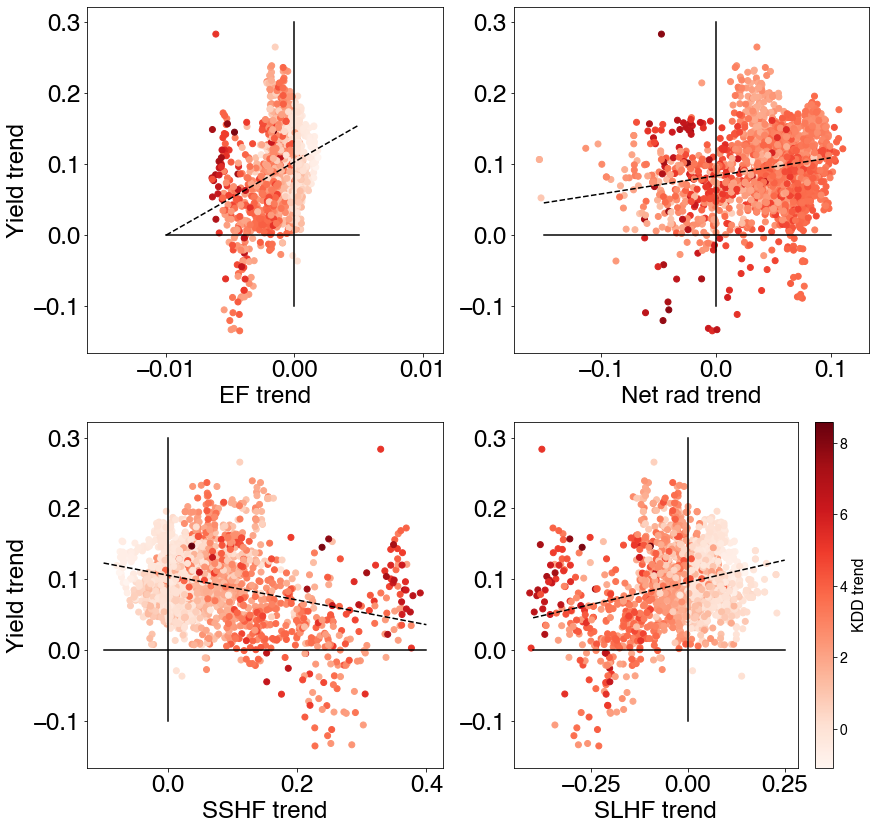

In [186]:
curCountyList = countyList.copy()
# curCountyList = curCountyList[curCountyList['STATE']=='MN']

kddTrendAgg = np.array([x for x in np.array(list(curCountyList['kddTrend']))])
gddTrendAgg = np.array([x for x in np.array(list(curCountyList['gddTrend']))])
prTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalPrecipTrend']))])
sshfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSshfTrend']))])
slhfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSlhfTrend']))])
efTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalEfTrend']))])
ssrTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSsrTrend']))])
strTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalStrTrend']))])
yieldTrendAgg = np.array([x for x in np.array(list(curCountyList['maizeYieldTrendDeepak']))])


# yieldTrendAgg *= 1000 / 10000
# for i,p in enumerate(paIrInds):
#     yieldTrendAgg[i] *= pa[p]/100
    
# convert from J/m2/growing season to mm/m2/growing season
sshfTrendAgg /= -1e6
slhfTrendAgg /= -1e6
ssrTrendAgg /= 1e6
strTrendAgg /= 1e6

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(gddTrendAgg)) & (~np.isnan(prTrendAgg)) & \
              (~np.isnan(sshfTrendAgg)) & (~np.isnan(slhfTrendAgg)) & (~np.isnan(efTrendAgg)) & (~np.isnan(yieldTrendAgg)))[0]

kddTrendAgg = kddTrendAgg[nn]
gddTrendAgg = gddTrendAgg[nn]
sshfTrendAgg = sshfTrendAgg[nn]
slhfTrendAgg = slhfTrendAgg[nn]
efTrendAgg = efTrendAgg[nn]
ssrTrendAgg = ssrTrendAgg[nn]
strTrendAgg = strTrendAgg[nn]
netRadTrendAgg = ssrTrendAgg+strTrendAgg
prTrendAgg = prTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]


# plt.figure()
# plt.scatter(netRadTrendAgg, slhfTrendAgg+sshfTrendAgg, s=30, c=kddTrendAgg, cmap='Reds')
# plt.plot([-.15, .15], [-.15, .15], '--k')
# plt.xlim([-.15, .15])
# plt.ylim([-.15, .2])
# plt.xlabel('Net radiation trend')
# plt.ylabel('Net heat flux trend')
# cbar = plt.colorbar()
# cbar.set_label('KDD trend')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14,14))


X = sm.add_constant(efTrendAgg)
mdlEf = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.01
x2 = .005
ax1.scatter(efTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax1.plot([0,0], [-.1, .3], 'k')
ax1.plot([x1, x2], [0, 0], 'k')
ax1.plot([x1, x2], [mdlEf.params[0]+x1*mdlEf.params[1], mdlEf.params[0]+x2*mdlEf.params[1]], '--k')
ax1.set_xlabel('EF trend', fontsize=24)
ax1.set_ylabel('Yield trend', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)


X = sm.add_constant(netRadTrendAgg)
mdlRad = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.15
x2 = .1
ax2.scatter(netRadTrendAgg, yieldTrendAgg, c=gddTrendAgg, cmap='Reds')
ax2.plot([0,0], [-.1, .3], '-k')
ax2.plot([x1, x2], [0, 0], '-k')
ax2.plot([x1, x2], [mdlRad.params[0]+x1*mdlRad.params[1], mdlRad.params[0]+x2*mdlRad.params[1]], '--k')
ax2.set_xlabel('Net rad trend', fontsize=24)
# ax2.set_ylabel('Yield trend', fontsize=24)
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)


X = sm.add_constant(sshfTrendAgg)
mdlSH = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.1
x2 = .4
ax3.scatter(sshfTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax3.plot([0,0], [-.1, .3], '-k')
ax3.plot([-.1, .4], [0, 0], '-k')
ax3.plot([x1, x2], [mdlSH.params[0]+x1*mdlSH.params[1], mdlSH.params[0]+x2*mdlSH.params[1]], '--k')
ax3.set_xlabel('SSHF trend', fontsize=24)
ax3.set_ylabel('Yield trend', fontsize=24)
ax3.tick_params(axis='x', labelsize=24)
ax3.tick_params(axis='y', labelsize=24)


X = sm.add_constant(slhfTrendAgg)
mdlLH = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.4
x2 = .25
a=ax4.scatter(slhfTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax4.plot([0,0], [-.1, .3], '-k')
ax4.plot([-.4, .25], [0, 0], '-k')
ax4.plot([x1, x2], [mdlLH.params[0]+x1*mdlLH.params[1], mdlLH.params[0]+x2*mdlLH.params[1]], '--k')
ax4.set_xlabel('SLHF trend', fontsize=24)
# ax4.set_ylabel('Yield trend', fontsize=24)
ax4.tick_params(axis='x', labelsize=24)
ax4.tick_params(axis='y', labelsize=24)
cbar = fig.colorbar(a,ax=ax4)
cbar.set_label('KDD trend')

# plt.savefig('yield-rad-ef-trends.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = .1)

# mdlLH.summary()


In [187]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
evapAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalEvapDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
yieldMdlNass = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
yieldMdlNass.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     6462.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:20:37   Log-Likelihood:            -2.7705e+05
No. Observations:               64484   AIC:                         5.541e+05
Df Residuals:                   64480   BIC:                         5.542e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0854      0.070     -1.219      0.223      -0.223       0.052
GDD            0.0235      0.001     28.178      0.000       0.022       0.025
KDD           -0.1670      0.002   -109.473      0.000      -0.170      -0.164
Pr            -0.2803      0.023    -12.343      0.000      -0.325      -0.236
==============================================================================
Omnibus:                     5333.863   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11436.034
Skew:                          -0.540   Prob(JB):                         0.00
Kurtosis:                       4.758   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
yieldMdlDeepak = smf.ols(formula='Yield ~ KDD + Pr', data=df).fit()
yieldMdlDeepak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.327e+04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:20:37   Log-Likelihood:            -1.0231e+05
No. Observations:               73765   AIC:                         2.046e+05
Df Residuals:                   73762   BIC:                         2.047e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0199      0.004      5.558      0.000       0.013       0.027
KDD           -0.0079   5.65e-05   -140.101      0.000      -0.008      -0.008
Pr            -0.0197      0.001    -17.075      0.000      -0.022      -0.017
==============================================================================
Omnibus:                     5110.355   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9175.835
Skew:                          -0.516   Prob(JB):                         0.00
Kurtosis:                       4.386   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
stateMdls = {}

# build state models
for state in usStateAbbrev.values():
    
    gddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['gddDetrend']))])))
    kddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['kddDetrend']))])))
    prAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['seasonalPrecipDetrend']))])))
    yieldAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['maizeYieldDetrendDeepak']))])))
    
    nn = np.where((~np.isnan(gddAgg)) & (~np.isnan(kddAgg)) & (~np.isnan(prAgg)) & (~np.isnan(yieldAgg)))[0]
    
    if len(nn) > 100:
#         print('building model for %s, n = %d'%(state, len(nn)))
    
        data = {'GDD':gddAgg[nn], \
            'KDD':kddAgg[nn], \
            'Pr':prAgg[nn], 'Pr2':prAgg[nn]**2, \
            'Yield':yieldAgg[nn]}

        df = pd.DataFrame(data, \
                          columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                   'Yield'])
        stateMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
        stateMdls[state] = stateMdl

In [190]:
countyFips = np.array(list(countyList['FIPS']))
states = np.array(list(countyList['STATE']))
startingYields = np.array(list(countyList['maizeYield']))
startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

In [191]:
if not useTrendMethod:

    if os.path.isfile('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)):
        with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']

            print('loaded %s'%('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        periodLen = range(5, 15)

        countyFips = np.array(list(countyList['FIPS']))
        states = np.array(list(countyList['STATE']))
        startingYields = np.array(list(countyList['maizeYield']))
        startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            for p in periodLen:

                curCountyGddStart = curCountyGdd[0:p]
                curCountyKddStart = curCountyKdd[0:p]
                curCountyPrStart = curCountyPr[0:p]

                curCountyGddEnd = curCountyGdd[len(curCountyGdd)-p:]
                curCountyKddEnd = curCountyKdd[len(curCountyKdd)-p:]
                curCountyPrEnd = curCountyPr[len(curCountyPr)-p:]

                XStart = {'GDD':curCountyGddStart, 'KDD':curCountyKddStart, 'Pr':curCountyPrStart, 'Pr2':curCountyPrStart**2, 'County':[c]*len(curCountyGddStart)}
                XEnd = {'GDD':curCountyGddEnd, 'KDD':curCountyKddEnd, 'Pr':curCountyPrEnd, 'Pr2':curCountyPrEnd**2, 'County':[c]*len(curCountyGddEnd)}

                predDeepak1 = mdlDeepak.predict(XStart).mean()
                predDeepak2 = mdlDeepak.predict(XEnd).mean()

                if predDeepak1 != 0:
                    predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                else:
                    predChgDeepak = np.nan

                pred1 = mdl.predict(XStart).mean()
                pred2 = mdl.predict(XEnd).mean()

                if pred1 != 0:
                    predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                else:
                    predChg = np.nan

                if countyModelExists:
                    predCounty1 = countyMdl.predict(XStart).mean()
                    predCounty2 = countyMdl.predict(XEnd).mean()

                    if predCounty1 != 0:
                        predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                    else:
                        predChgCounty = np.nan
                else:
                    predChgCounty = np.nan

                if states[c] in stateMdls.keys():
                    predState1 = stateMdls[states[c]].predict(XStart).mean()
                    predState2 = stateMdls[states[c]].predict(XEnd).mean()

                    if predState1 != 0:
                        predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                    else:
                        predChgState = np.nan
                else:
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(curCountyGddEnd) - np.nanmean(curCountyGddStart))
                curCountyKddChg.append(np.nanmean(curCountyKddEnd) - np.nanmean(curCountyKddStart))
                curCountyPrChg.append(np.nanmean(curCountyPrEnd) - np.nanmean(curCountyPrStart))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = np.nanmean(curCountyOutcomes)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = np.nanmean(curCountyOutcomesCounty)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = np.nanmean(curCountyOutcomesState)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = np.nanmean(curCountyOutcomesDeepak)

            countyGddChg[c] = np.nanmean(curCountyGddChg)
            countyKddChg[c] = np.nanmean(curCountyKddChg)
            countyPrChg[c] = np.nanmean(curCountyPrChg)

            countyModelData = {'countyOutcomes':countyOutcomes, \
                               'countyOutcomesCounty':countyOutcomesCounty, \
                               'countyOutcomesState':countyOutcomesState, \
                               'countyOutcomesDeepak':countyOutcomesDeepak, \
                               'countyGddChg':countyGddChg, \
                               'countyKddChg':countyKddChg, \
                               'countyPrChg':countyPrChg}
            with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
                pickle.dump(countyModelData, f)

In [200]:
if useTrendMethod:
    
    rebuild = True
    
    if os.path.isfile('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
#             countyClimYieldEffect = countyModelData['countyClimYieldEffect']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']
#             countyEvapChg = countyModelData['countyEvapChg']

            print('loaded %s'%('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        
        # how many kdd/gdd/pr slopes to generate by leaving out years
        leaveOutN = 100
        
        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        
#         countyClimYieldEffect = {}
        
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}
        countyEvapChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            
#             curCountyClimYieldEffect = []
            
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []
            curCountyEvapChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                yieldMdlCounty = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]
            curCountyEvap = np.array(list(usCounties['seasonalEvap']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            # calc climate-induced yield anomalies for every year
#             XBase = {'GDD':[np.nanmean(curCountyGdd)], \
#                      'KDD':[np.nanmean(curCountyKdd)], \
#                      'Pr':[np.nanmean(curCountyPr)]}
#             if not np.isnan(XBase['GDD']) and not np.isnan(XBase['KDD']) and not np.isnan(XBase['Pr']):
#                 yieldBase = yieldMdlNass.predict(XBase).values[0]
#                 XYears = {'GDD':curCountyGdd, \
#                           'KDD':curCountyKdd, \
#                           'Pr':curCountyPr}
#                 curCountyClimYieldEffect = mdl.predict(XYears).values - yieldBase
#             countyClimYieldEffect[c] = curCountyClimYieldEffect   
            
            for n in range(leaveOutN):
            
                inds = np.arange(0, len(curCountyKdd))
                inds = random.sample(set(inds), len(inds)-2)
                inds.sort()
                         
                X = sm.add_constant(range(len(curCountyKdd[inds])))
                curCountyKddMdl = sm.OLS(curCountyKdd[inds], X).fit()
                curCountyKddInt = curCountyKddMdl.params[0]
                curCountyKddTrend = curCountyKddMdl.params[1]

                X = sm.add_constant(range(len(curCountyGdd[inds])))
                curCountyGDDMdl = sm.OLS(curCountyGdd[inds], X).fit()
                curCountyGddInt = curCountyGDDMdl.params[0]
                curCountyGddTrend = curCountyGDDMdl.params[1]

                X = sm.add_constant(range(len(curCountyPr[inds])))
                curCountyPrMdl = sm.OLS(curCountyPr[inds], X).fit()
                curCountyPrInt = curCountyPrMdl.params[0]
                curCountyPrTrend = curCountyPrMdl.params[1]
                
                X = sm.add_constant(range(len(curCountyEvap[inds])))
                curCountyEvapMdl = sm.OLS(curCountyEvap[inds], X).fit()
                curCountyEvapInt = curCountyEvapMdl.params[0]
                curCountyEvapTrend = curCountyEvapMdl.params[1]
                                 
                XStart = {'GDD':[curCountyGddInt], \
                        'KDD':[curCountyKddInt], \
                        'Pr':[curCountyPrInt], \
                         'Evap':[curCountyEvapInt]}
                XEnd = {'GDD':[(curCountyGddInt+curCountyGddTrend*(2020-1979))], \
                        'KDD':[(curCountyKddInt+curCountyKddTrend*(2020-1979))], \
                        'Pr':[(curCountyPrInt+curCountyPrTrend*(2020-1979))], \
                        'Evap':[(curCountyEvapInt+curCountyEvapTrend*(2020-1979))]}

                if not np.isnan(XStart['GDD']) and not np.isnan(XStart['KDD']) and not np.isnan(XStart['Pr']) and \
                   not np.isnan(XEnd['GDD']) and not np.isnan(XEnd['KDD']) and not np.isnan(XEnd['Pr']):
                    predDeepak1 = yieldMdlDeepak.predict(XStart).values[0]
                    predDeepak2 = yieldMdlDeepak.predict(XEnd).values[0]

                    if predDeepak1 != 0:
                        predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                    else:
                        predChgDeepak = np.nan

                    pred1 = yieldMdlNass.predict(XStart).values[0]
                    pred2 = yieldMdlNass.predict(XEnd).values[0]

                    if pred1 != 0:
                        predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                    else:
                        predChg = np.nan

                    if countyModelExists:
                        predCounty1 = yieldMdlCounty.predict(XStart).values[0]
                        predCounty2 = yieldMdlCounty.predict(XEnd).values[0]

                        if predCounty1 != 0:
                            predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                        else:
                            predChgCounty = np.nan
                    else:
                        predChgCounty = np.nan

                    if states[c] in stateMdls.keys():
                        predState1 = stateMdls[states[c]].predict(XStart).values[0]
                        predState2 = stateMdls[states[c]].predict(XEnd).values[0]

                        if predState1 != 0:
                            predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                        else:
                            predChgState = np.nan
                    else:
                        predChgState = np.nan
                else:
                    predChgDeepak = np.nan
                    predChg = np.nan
                    predChgCounty = np.nan
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(XEnd['GDD']) - np.nanmean(XStart['GDD']))
                curCountyKddChg.append(np.nanmean(XEnd['KDD']) - np.nanmean(XStart['KDD']))
                curCountyPrChg.append(np.nanmean(XEnd['Pr']) - np.nanmean(XStart['Pr']))
                curCountyEvapChg.append(np.nanmean(XEnd['Evap']) - np.nanmean(XStart['Evap']))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = curCountyOutcomes

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = curCountyOutcomesCounty

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = curCountyOutcomesState

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = curCountyOutcomesDeepak
            
            countyGddChg[c] = curCountyGddChg
            countyKddChg[c] = curCountyKddChg
            countyPrChg[c] = curCountyPrChg
            countyEvapChg[c] = curCountyEvapChg

        countyModelData = {'countyOutcomes':countyOutcomes, \
                           'countyOutcomesCounty':countyOutcomesCounty, \
                           'countyOutcomesState':countyOutcomesState, \
                           'countyOutcomesDeepak':countyOutcomesDeepak, \
#                            'countyClimYieldEffect':countyClimYieldEffect, \
                           'countyGddChg':countyGddChg, \
                           'countyKddChg':countyKddChg, \
                           'countyPrChg':countyPrChg, \
                           'countyEvapChg':countyEvapChg}
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
            pickle.dump(countyModelData, f)

0 %
2 %
4 %
7 %
9 %
11 %
13 %
16 %
18 %
20 %
22 %
24 %
27 %
29 %
31 %
33 %
36 %
38 %
40 %
42 %
44 %
47 %
49 %
51 %
53 %
56 %
58 %
60 %
62 %
65 %
67 %
69 %
71 %
73 %
76 %
78 %
80 %
82 %
85 %
87 %
89 %
91 %
93 %
96 %
98 %


In [201]:
mapFontSize=30

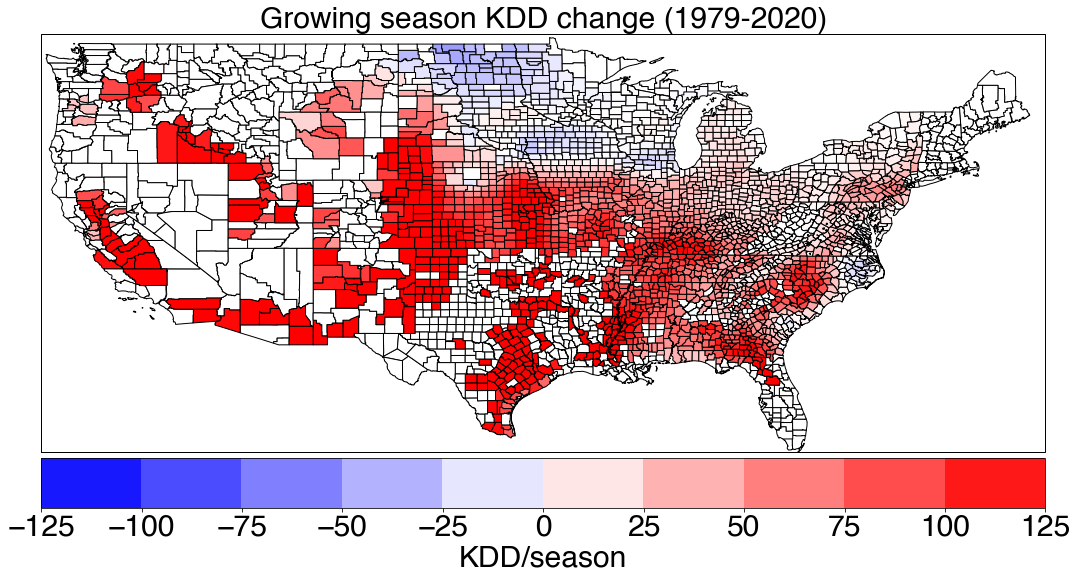

In [202]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

fig = plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-125, vmax=125)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyKddChg.keys():
        curKddChg = np.nanmean(countyKddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curKddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Growing season KDD change (1979-2020)', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-125,126,25), 
             boundaries=np.arange(-125,126,25), orientation='horizontal',
             pad=0.01)
cb.set_label('KDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-kdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

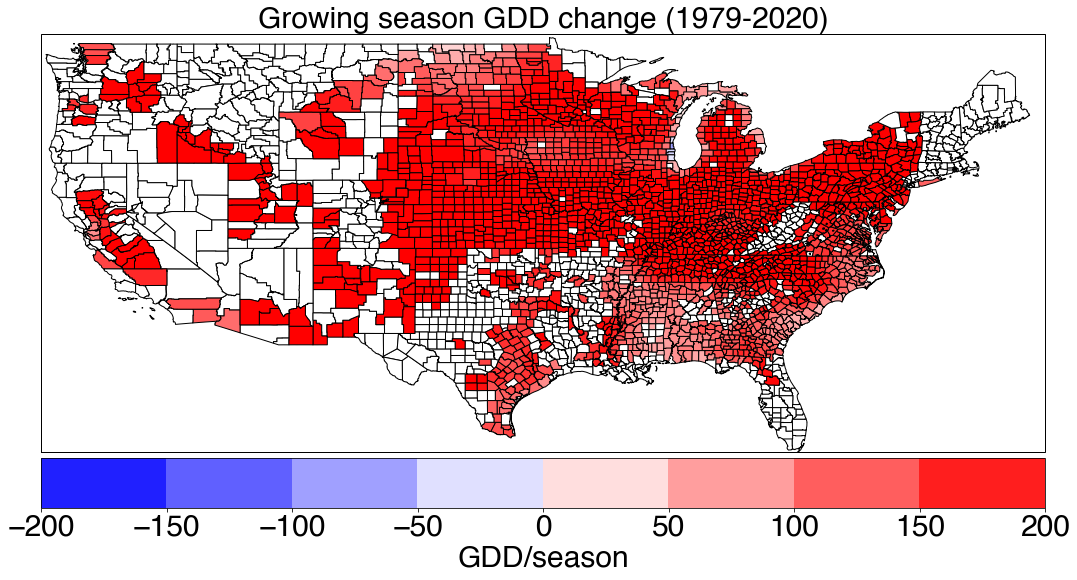

In [203]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-200, vmax=200)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyGddChg.keys():
        curGddChg = np.nanmean(countyGddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curGddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season GDD change (1979-2020)', fontsize=mapFontSize)        
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-200,201,50), 
             boundaries=np.arange(-200,201,50), orientation='horizontal',
             pad=0.01)
cb.set_label('GDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-gdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

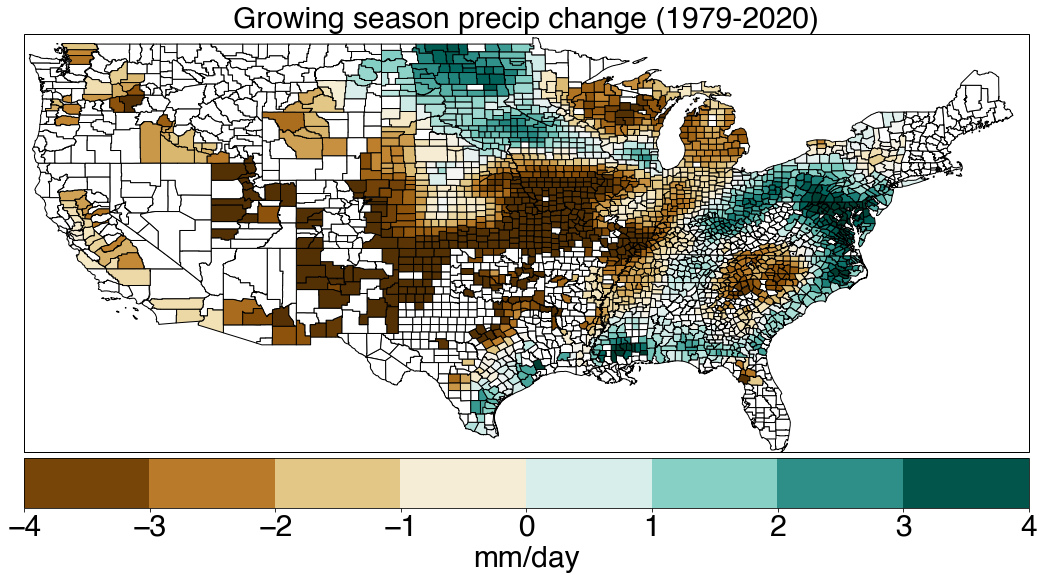

In [204]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-4, vmax=4)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyPrChg.keys():
        curPrChg = np.nanmean(countyPrChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curPrChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season precip change (1979-2020)', fontsize=mapFontSize)    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-4,4.1,1), 
             boundaries=np.arange(-4,4.1,1), orientation='horizontal',
             pad=0.01)
cb.set_label('mm/day', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-pr-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

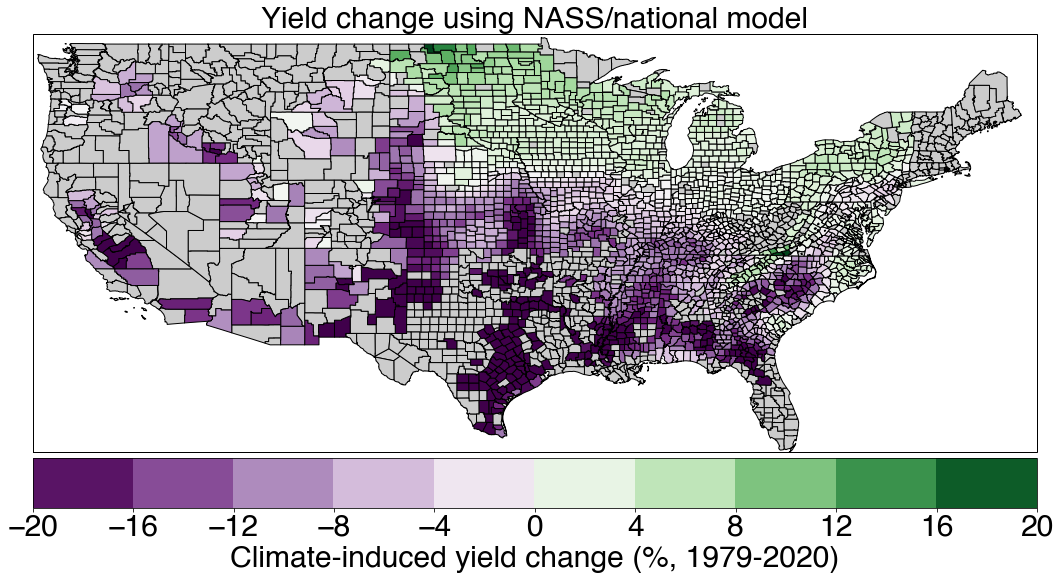

In [205]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomes.keys():
        curYieldChg = np.nanmean(countyOutcomes[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Climate-induced yield change (%, 1979-2020)', fontsize=mapFontSize)
# plt.savefig('us-yield-chg-nass-national.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

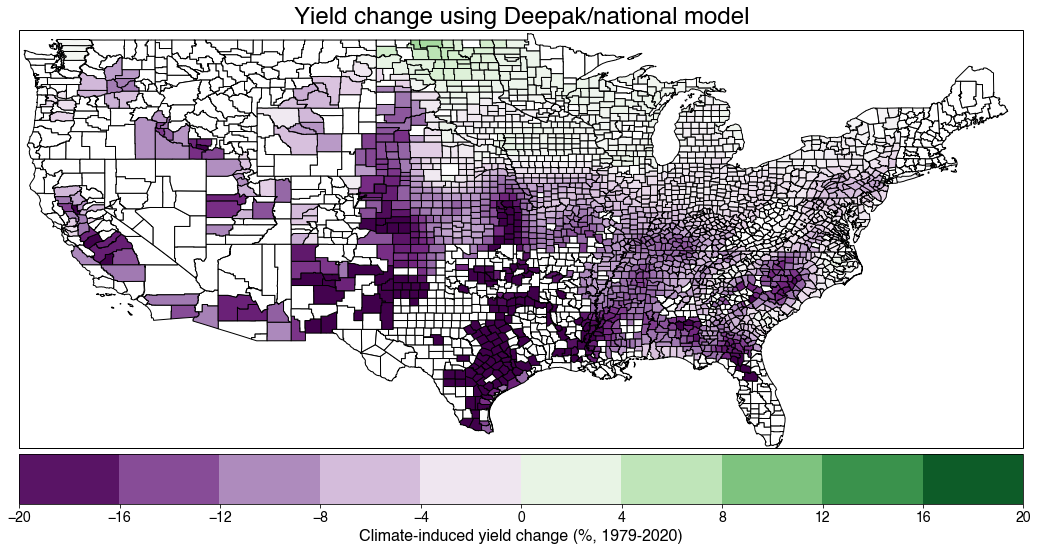

In [206]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = np.nanmean(countyOutcomesDeepak[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/national model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
# plt.savefig('us-yield-chg-deepak-national.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

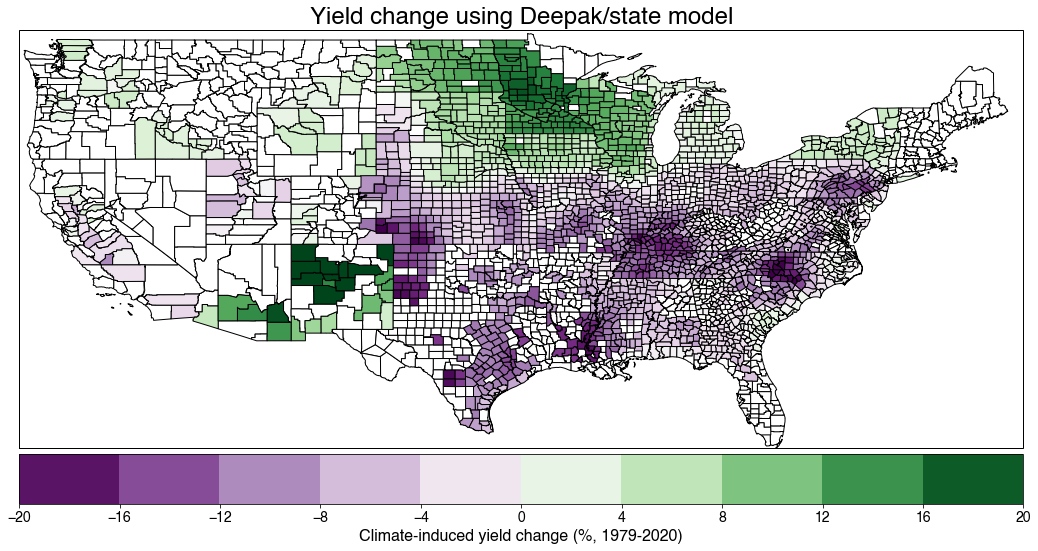

In [207]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesState.keys():
        curYieldChg = np.nanmean(countyOutcomesState[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/state model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

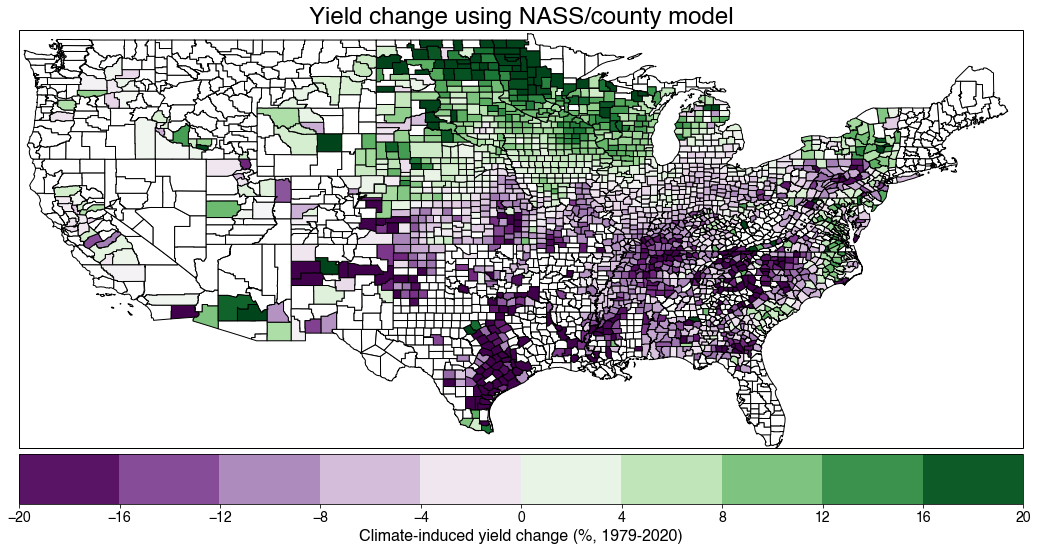

In [208]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesCounty.keys():
        curYieldChg = np.nanmean(countyOutcomesCounty[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using NASS/county model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

In [ ]:
startPeriod = range(2, 25)
startPeriod = [5]

lowYieldThresh = 25
highYieldThresh = 75

useDeepak = True

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

lowYieldChg = []
allYieldChg = []
allMeanYield = []
allStartingYield = []
highYieldChg = []

lowProd = []
lowProdChg = []
allProdChg = []
allProd = []
highProd = []
highProdChg = []

for spInd, sp in enumerate(startPeriod):        
    startingYields = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh)))[0]
    indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh)))[0]

    if useDeepak:
        projYieldChg = countyOutcomesDeepak
    else:
        projYieldChg = countyOutcomes

    for i in indLow:
        if i in projYieldChg.keys():
            lowYieldChg.append(projYieldChg[i])
            lowProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            lowProd.append(np.nanmean(allCountyProd[i]))
    for i in indHigh:
        if i in projYieldChg.keys():
            highYieldChg.append(projYieldChg[i])
            highProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            highProd.append(np.nanmean(allCountyProd[i]))
    for i in projYieldChg.keys():
        allYieldChg.append(projYieldChg[i])
        allMeanYield.append(np.nanmean(allCountyYields[i,:]))
        allStartingYield.append(startingYields[i])
        allProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
        allProd.append(np.nanmean(allCountyProd[i]))
        
lowYieldChg = np.nanmean(np.array(lowYieldChg), axis=1)
highYieldChg = np.nanmean(np.array(highYieldChg), axis=1)
allYieldChg = np.nanmean(np.array(allYieldChg), axis=1)
allMeanYield = np.array(allMeanYield)
allStartingYield = np.array(allStartingYield)

lowProdChg = np.array(lowProdChg)
lowProd = np.array(lowProd)

allProdChg = np.array(allProdChg)
allProd = np.array(allProd)

highProdChg = np.array(highProdChg)
highProd = np.array(highProd)


In [ ]:
X = sm.add_constant(allMeanYield)
mdl = sm.OLS(allYieldChg, X).fit()

x1 = 3.5
x2 = 11.5

plt.figure(figsize=(6,6))
plt.xlim([2.5, 12.5])
plt.scatter(allMeanYield, allYieldChg, c='#5bc718')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='p < 0.01')
plt.plot([2.5, 12.5], [0, 0], '-k', lw=1)
plt.xlabel('Mean yield (t/ha)', fontsize=20)
plt.ylabel('Climate-induced yield change (%)', fontsize=20)
plt.yticks(np.arange(-50, 21, 10))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
plt.savefig('climate-yield-trends-vs-mean-yield.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.1)


In [ ]:
print(np.nanmedian(lowProdChg)/np.nanmean(lowProd)*100)
print(np.nanmedian(highProdChg)/np.nanmean(highProd)*100)
print(np.nanmedian(allProdChg)/np.nanmean(allProd)*100)

In [ ]:
print(np.nanmedian(lowYieldChg))
print(np.nanmedian(highYieldChg))
print(np.nanmedian(allYieldChg))

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(7, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(lowYieldChg, density=True, color='#5bc718')
ax1.set_xlim([-50, 30])
ax1.set_ylim([0, .07])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(lowYieldChg), np.nanmedian(lowYieldChg)], [0, 0.07], '--k', lw=2, label='Low productivity\n(< %dth percentile)\nyield change'%lowYieldThresh)
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l1.get_frame().set_linewidth(0)

ax2.hist(highYieldChg, density=True, color='#5bc718')
ax2.set_xlim([-50, 30])
ax2.set_ylim([0, .07])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(highYieldChg), np.nanmedian(highYieldChg)], [0, 0.07], '--k', lw=2, label='High productivity\n(> %dth percentile)\nyield change'%highYieldThresh)
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l2.get_frame().set_linewidth(0)

ax3.hist(allYieldChg, density=True, color='#5bc718')
ax3.set_xlim([-50, 30])
ax3.set_ylim([0, .07])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(allYieldChg), np.nanmedian(allYieldChg)], [0, 0.07], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l3.get_frame().set_linewidth(0)

plt.savefig('us-yield-chg-by-mean-yield.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
ks_pl_pa = scipy.stats.ks_2samp(lowYieldChg, allYieldChg)
ks_pl_ph = scipy.stats.ks_2samp(lowYieldChg, highYieldChg)
ks_ph_pa = scipy.stats.ks_2samp(highYieldChg, allYieldChg)

print('KS-test: low productivity vs all counties: %.10f'%ks_pl_pa.pvalue)
print('KS-test: low productivity vs high productivity counties: %.10f'%ks_pl_ph.pvalue)
print('KS-test: high productivity vs all counties: %.10f'%ks_ph_pa.pvalue)

In [ ]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

In [ ]:
startPeriod = range(7, 14)
endPeriod = range(7, 14)

yieldRangeThreshLen = 10
lowYieldThresh = range(20,20+yieldRangeThreshLen)
highYieldThresh = range(70,70+yieldRangeThreshLen)

pl = []
ph = []
pa = []
weightedProdChg = []

N = yieldRangeThreshLen*len(startPeriod)*len(endPeriod)
n = 0

useDeepak = True

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

for r in range(yieldRangeThreshLen):

    for sp in startPeriod:
        
        startingYields = []
        countyInds = []
        for startingYield in np.array(list(countyList[yieldVar])):
            indStart = np.where(~np.isnan(startingYield))[0][0]
            indEnd = np.where(~np.isnan(startingYield))[0][-1]

            countyInds.append((indStart, indEnd))

            ind2 = indStart+sp
            if ind2 > len(startingYield): 
                ind2 = len(startingYield)
            startingYields.append(np.nanmean(startingYield[indStart:ind2]))

        indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh[r])))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh[r])))[0]

        for ep in endPeriod:
            
            if n % 100 == 0:
                print('%.0f %%'%(n/N*100))
            
            n += 1
            
            gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indLow])))
            
            gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indLow])))

            gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indHigh])))

            gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indHigh])))
            
            countyYieldsLow = np.array([np.nanmean(allCountyYields[c,:]) for c in indLow])
            countyYieldsHigh = np.array([np.nanmean(allCountyYields[c,:]) for c in indHigh])
            countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])

            XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2, 'County':countyFELowStart}
            XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2, 'County':countyFELowEnd}
            XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2, 'County':countyFEHighStart}
            XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2, 'County':countyFEHighEnd}
            XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2, 'County':countyFEAllStart}
            XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2, 'County':countyFEAllEnd}

            if useDeepak:
                predLow1 = mdlDeepak.predict(XLowStart).mean()
                predLow2 = mdlDeepak.predict(XLowEnd).mean()
            else:
                predLow1 = mdl.predict(XLowStart).mean()
                predLow2 = mdl.predict(XLowEnd).mean()
            if predLow1 > 0 and predLow2 > 0:
                predLow = (predLow2-predLow1)/np.nanmean(countyYieldsLow)*100
                if predLow < -100 or predLow > 500:
                    predLow = np.nan
            else:
                predLow = np.nan

            if useDeepak:
                predHigh1 = mdlDeepak.predict(XHighStart).mean()
                predHigh2 = mdlDeepak.predict(XHighEnd).mean()
            else:
                predHigh1 = mdl.predict(XHighStart).mean()
                predHigh2 = mdl.predict(XHighEnd).mean()
            if predHigh1 > 0 and predHigh2 > 0:
                predHigh = (predHigh2-predHigh1)/np.nanmean(countyYieldsHigh)*100
                if predHigh < -100 or predHigh > 500:
                    predHigh = np.nan
            else:
                predHigh = np.nan

            if useDeepak:
                predAll1 = mdlDeepak.predict(XAllStart).mean()
                predAll2 = mdlDeepak.predict(XAllEnd).mean()
            else:
                predAll1 = mdl.predict(XAllStart).mean()
                predAll2 = mdl.predict(XAllEnd).mean()
            if predAll1 > 0 and predAll2 > 0:
                predAll = (predAll2-predAll1)/np.nanmean(countyYieldsAll)*100
                if predAll < -100 or predAll > 500:
                    predAll = np.nan
            else:
                predAll = np.nan

            pl.append(predLow)
            ph.append(predHigh)
            pa.append(predAll)

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

In [ ]:
len(ph)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-10, 5])
ax1.set_ylim([0, .3])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(pl), np.nanmedian(pl)], [0, 0.3], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-10, 5])
ax2.set_ylim([0, .3])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(ph), np.nanmedian(ph)], [0, 0.3], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-10, 5])
ax3.set_ylim([0, .3])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(pa), np.nanmedian(pa)], [0, 0.3], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

In [ ]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

In [ ]:
print('%.2f'%(np.nansum(np.nanmean(allCountyProdChg, axis=1))/np.nansum(allCountyProd)*100))
print('%.2f'%(np.nanmean(np.nanmean(allCountyYieldChg, axis=1)/np.nanmean(allCountyYields, axis=1))*100))